# Trabajo de Grado - SITP

## Recursos

In [102]:
import pandas as pd
import scipy
import numpy as np

# --- PARCHE DE COMPATIBILIDAD (Monkey Patch) ---
# Scipy eliminó funciones antiguas que factor_analyzer necesita.
# Aquí las restauramos redirigiéndolas a Numpy.

def patch_scipy():
    funcs_to_patch = {
        "dot": np.dot,
        "sum": np.sum,
        "diag": np.diag,
        "sqrt": np.sqrt,
        "exp": np.exp,
        "log": np.log,
        "abs": np.abs
    }
    for func_name, func_ref in funcs_to_patch.items():
        if not hasattr(scipy, func_name):
            setattr(scipy, func_name, func_ref)

patch_scipy()
# -----------------------

import openpyxl
import warnings
from pandas.errors import PerformanceWarning
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore', category=PerformanceWarning)
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

####### AFE
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

### aLFA CRONBACH
import pingouin as pg

### CFA
from semopy import Model, calc_stats
from itertools import combinations

### MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



In [6]:
#data = pd.read_excel("C:\\Users\\cozabd01\\Downloads\\movilidad.xlsx", sheet_name = "BASE NUMERICA")
data = pd.read_excel("C:\\Users\\david\\Downloads\\movilidad.xlsx", sheet_name = "BASE NUMERICA")
data.head()

,ID,Localidad,UPL,A1,F1,F2_1,F2_2,F2_3,F2_4,F2_5,...,REDAD,P802,P8031,P8032,P907,COD_SECT,COD_SECC,FACTOR_1,FACTOR_2,RIESGO
0,1,1,3,1,1,1,,,,,...,3,4,5,NaN,1,1.100110e+17,11001100000000240906,518.739601,775.647171,0
1,2,1,3,1,1,,,,,5,...,5,3,1,NaN,2,1.100110e+17,11001100000000240906,627.861555,775.647171,0
2,3,1,3,1,1,1,,,,,...,6,2,5,NaN,1,1.100110e+17,11001100000000240906,588.495803,775.647171,0
3,4,1,3,1,1,1,,,,,...,3,4,5,NaN,1,1.100110e+17,11001100000000240906,518.739601,775.647171,0
4,5,1,3,1,1,1,,,,,...,5,3,5,NaN,2,1.100110e+17,11001100000000240906,627.861555,775.647171,0


In [120]:
df = data.copy()

## Limpieza

In [121]:
## Filtrar base en transporte usual in (1,2,3)
df = df[df['P2'].isin([1, 2, 3, 4])]

In [122]:
## columnas de mi interés
columnas = ['ID', 'Localidad', 'UPL',
    'F1', 'P2', 'P800_1', 'P801', 'P802', 'P8031', 'FACTOR_1', 'FACTOR_2', 'P3', 'P4_1', 'P4_2', 'P5_1', 'P5_2', 'P5_3',
    'P6_1', 'P6_2', 'P6_3', 'P6_4', 'P6_5', 'P6_6', 'P6_7', 'P6_8', 'P6_9', 'P6_10', 'P6_11', 'P6_12', # RAZON DE USO DE TRANSPORTE
    'P7_1', 'P7_2', 'P7_3', 'P7_4', 'P7_5', 'P7_6', 'P7_7', 'P7_8', 'P7_9', 'P7_10', 'P7_11', 'P7_12', 'P7_13', 'P7_14', 'P7_15', 'P7_16', 'P7_17', # SATISFACCION TRANSPORTE
    'P8_1', 'P8_2', 'P8_3', #SEGURIDAD
    'P9_1', 'P9_2', 'P9_3', 'P9_4', 'P9_5', 'P9_6', 'P9_7', 'P9_8', 'P9_9', 'P9_10', 'P9_11', 'P9_12', 'P9_13', 'P9_14', 'P9_15', 'P9_16', # RIESGO PERCEBIDO
    'P10_1', 'P10_2', 'P10_3', #VARIACION DIMENSIONES
    'P11', 'P12', 'P13', 'P14', 'P15', # GOLPE, ATENCION, ACCIDENTE, SEVERIDAD, ATENCION 
    ##### TERMINA COMPONENTE TRANSMILENIO, SIGUE ENTORNOS URBANOS
    'P129', # SATISFACCION CIUDAD
    'P130_1', 'P130_2', 'P130_3', 'P130_4', 'P130_5', 'P130_6', 'P130_7', 'P130_8', 'P130_9', 'P130_10', 'P130_11', 'P130_12', 'P130_13', 'P130_14', 'P130_15',
    'P130_16', 'P130_17', 'P130_18', 'P130_19', 'P130_20', 'P130_21', 'P130_22', 'P130_23', 'P130_24', 'P130_25', 'P130_26', 'P130_27', #SATISFACCION ELEMENTOS BARRIO
    'P131_1', 'P131_2', 'P131_3', 'P131_4', 'P131_5', 'P131_6', 'P131_7', 'P131_8', 'P131_9', 'P131_10', 'P131_11', 'P131_12', 'P131_13', 'P131_14', 'P131_15', 
    'P131_16', 'P131_17', 'P131_18', 'P131_19', 'P131_20', 'P131_21', 'P131_22', # SEGURIDAD ELEMENTOS BARRIO
    #### PERSPECTIVAS DE MOVILIDAD
    'P145', 'P146', 'P147_1', 'P147_2', 'P148', 'P149_1', 'P149_2', 'P150_1', 'P150_2', ## CAMBIAR O CAMBIO DE TRANSPORTE
    'P151', 'P152', #USO METRO Y VARIACION MOVILIDAD
]

df = df[columnas]
df.head()

,ID,Localidad,UPL,F1,P2,P800_1,P801,P802,P8031,FACTOR_1,...,P146,P147_1,P147_2,P148,P149_1,P149_2,P150_1,P150_2,P151,P152
3,4,1,3,1,4,2,41,4,5,518.739601,...,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,3
8,9,1,3,1,4,2,25,5,5,422.586518,...,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,2
17,18,1,3,1,4,2,65,3,4,627.861555,...,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,1,1
18,19,1,3,1,2,2,70,3,5,825.482177,...,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,1
23,24,1,3,1,2,2,27,3,1,422.586518,...,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,1,2


In [123]:
## renombrar columnas
df = df.rename(columns={ 'F1': 'Loc_may', # localidad"
                        'P2': 'Transporte_usual', 'P3': 'Hist Uso', # transporte usual
                        'P800_1': 'Genero', 'P801': 'Edad', 'P802': 'Nivel_Educativo' , 'P8031': 'Ocupacion',
                        'FACTOR_1': 'Factor_Localidad', 'FACTOR_2': 'Factor_UPL' , 'P4_1' : 'USO_ES', 'P4_2' : 'USO_FDS',
                        'P5_1' : 'USO_MAÑANA', 'P5_2' : 'USO_TARDE', 'P5_3' : 'USO_NOCHE', 
                        'P6_1' : 'RAZON_UO', 'P6_2' : 'RAZON_RAP', 'P6_3' : 'RAZON_P&P', 'P6_4' : 'RAZON_SEG', 'P6_5' : 'RAZON_ECO', 'P6_6' : 'RAZON_CONT',
                        'P6_7' : 'RAZON_CERC', 'P6_8' : 'RAZON_COM', 'P6_9' : 'RAZON_COND', 'P6_10' : 'RAZON_OTRO', 'P6_11' : 'RAZON_NSNR', 'P6_12' : 'RAZON_OTROCUAL',
                        'P7_1' : 'SAT_1', 'P7_2' : 'SAT_2', 'P7_3' : 'SAT_3', 'P7_4' : 'SAT_4', 'P7_5' : 'SAT_5', 'P7_6' : 'SAT_6',
                        'P7_7' : 'SAT_7', 'P7_8' : 'SAT_8', 'P7_9' : 'SAT_9', 'P7_10' : 'SAT_10', 'P7_11' : 'SAT_11', 'P7_12' : 'SAT_12',
                        'P7_13' : 'SAT_13', 'P7_14' : 'SAT_14', 'P7_15' : 'SAT_15', 'P7_16' : 'SAT_16', 'P7_17' : 'SAT_17',
                        'P8_1' : 'SEG_1', 'P8_2' : 'SEG_2', 'P8_3' : 'SEG_3',
                        'P9_1' : 'CD_CANT', 'P9_2' : 'CD_MAL_ILU', 'P9_3' : 'CD_VENDEDORES', 'P9_4' : 'CD_POLIC', 'P9_5' : 'CD_COLADOS',
                        'P9_6' : 'CD_CONTVIS', 'P9_7' : 'CD_CONTAUD', 'P9_8' : 'CD_ASEO', 'P9_9' : 'CD_TRANCONES', 'P9_10' : 'CD_SEÑAL',
                        'P9_11' : 'CD_ACOSO', 'P9_12' : 'CD_VEL_CONDUC', 'P9_13' : 'CD_VEL_VEHI', 'P9_14' : 'CD_NSNR', 'P9_15' : 'CD_OTRO', 'P9_16' : 'CD_OTROCUAL',
                        'P10_1' : 'VAR_MOV', 'P10_2' : 'VAR_SEG', 'P10_3' : 'VAR_COSTO',
                        'P11': 'GOLPE', 'P12': 'ATENCION_GOLPE', 'P13': 'ACCIDENTE', 'P14': 'SEVERIDAD_ACC', 'P15': 'ATENCION_ACC',
                        'P129': 'SAT_CIUDAD',
                        'P130_1': 'SAT_BARRIO_1', 'P130_2': 'SAT_BARRIO_2', 'P130_3': 'SAT_BARRIO_3', 'P130_4': 'SAT_BARRIO_4', 'P130_5': 'SAT_BARRIO_5',
                        'P130_6': 'SAT_BARRIO_6', 'P130_7': 'SAT_BARRIO_7', 'P130_8': 'SAT_BARRIO_8', 'P130_9': 'SAT_BARRIO_9', 'P130_10': 'SAT_BARRIO_10',
                        'P130_11': 'SAT_BARRIO_11', 'P130_12': 'SAT_BARRIO_12', 'P130_13': 'SAT_BARRIO_13', 'P130_14': 'SAT_BARRIO_14', 'P130_15': 'SAT_BARRIO_15',
                        'P130_16': 'SAT_BARRIO_16', 'P130_17': 'SAT_BARRIO_17', 'P130_18': 'SAT_BARRIO_18', 'P130_19': 'SAT_BARRIO_19', 'P130_20': 'SAT_BARRIO_20',
                        'P130_21': 'SAT_BARRIO_21', 'P130_22': 'SAT_BARRIO_22', 'P130_23': 'SAT_BARRIO_23', 'P130_24': 'SAT_BARRIO_24', 'P130_25': 'SAT_BARRIO_25',
                        'P130_26': 'SAT_BARRIO_26', 'P130_27': 'SAT_BARRIO_27',
                        'P131_1': 'SEG_BARRIO_1', 'P131_2': 'SEG_BARRIO_2', 'P131_3': 'SEG_BARRIO_3', 'P131_4': 'SEG_BARRIO_4', 'P131_5': 'SEG_BARRIO_5',
                        'P131_6': 'SEG_BARRIO_6', 'P131_7': 'SEG_BARRIO_7', 'P131_8': 'SEG_BARRIO_8', 'P131_9': 'SEG_BARRIO_9', 'P131_10': 'SEG_BARRIO_10',
                        'P131_11': 'SEG_BARRIO_11', 'P131_12': 'SEG_BARRIO_12', 'P131_13': 'SEG_BARRIO_13', 'P131_14': 'SEG_BARRIO_14', 'P131_15': 'SEG_BARRIO_15',
                        'P131_16': 'SEG_BARRIO_16', 'P131_17': 'SEG_BARRIO_17', 'P131_18': 'SEG_BARRIO_18', 'P131_19': 'SEG_BARRIO_19', 'P131_20': 'SEG_BARRIO_20',
                        'P131_21': 'SEG_BARRIO_21', 'P131_22': 'SEG_BARRIO_22',
                        'P145': 'CAMBIO_TRANSP', 'P146': 'TRANSP_ANTERIOR', 'P147_1': 'RAZON_CAMBIO', 'P147_2': 'RAZON_OTROCUAL',
                        'P148': 'PENSAR_CAMBIO', 'P149_1': 'NUEVO_TRANSP', 'P149_2': 'NUEVO_TRANSP_OTROCUAL',
                        'P150_1' : 'RAZON_CAMBIARIA', 'P150_2' : 'RAZON_CAMBIARIA_OTROCUAL',
                        'P151': 'USO_METRO', 'P152': 'VAR_MOVILIDAD'
                        })

In [124]:
# 1. Identificar las columnas que son 100% nulas
nulos_completos = df.columns[df.isnull().all()].tolist()

# 2. Informar al usuario (útil para tu registro de limpieza)
if nulos_completos:
    print(f"✅ Se eliminaron {len(nulos_completos)} columnas por estar completamente vacías:")
    print(nulos_completos)
else:
    print("ℹ️ No se encontraron columnas completamente nulas.")

# 3. Eliminar las columnas identificadas
df = df.drop(columns=nulos_completos)

✅ Se eliminaron 3 columnas por estar completamente vacías:
['RAZON_OTRO', 'RAZON_OTROCUAL', 'NUEVO_TRANSP_OTROCUAL']


In [125]:
imputar_nulos = ['USO_MAÑANA', 'USO_TARDE', 'USO_NOCHE', 'RAZON_UO', 'RAZON_RAP', 'RAZON_P&P', 'RAZON_SEG', 'RAZON_ECO', 
                 'RAZON_CONT', 'RAZON_CERC', 'RAZON_COM', 'RAZON_COND', 'CD_CANT', 'CD_MAL_ILU', 'CD_VENDEDORES', 'CD_POLIC', 'CD_COLADOS', 
                 'CD_CONTVIS', 'CD_CONTAUD', 'CD_ASEO', 'CD_TRANCONES', 'CD_SEÑAL', 'CD_ACOSO', 'CD_VEL_CONDUC', 'CD_VEL_VEHI', 'CD_OTRO'
]

# Reemplaza nulos por 0 en todas ellas
df[imputar_nulos] = df[imputar_nulos].fillna(0)

In [126]:
# 1. Seleccionamos las columnas desde la 10 en adelante que sean numéricas
cols_numericas = df.iloc[:, 9:].select_dtypes(include=[np.number]).columns

# 2. Aplicamos el reemplazo solo en esas columnas
df[cols_numericas] = df[cols_numericas].replace(99, np.nan)

# 3. Verificación rápida
print(f"✅ Se procesaron {len(cols_numericas)} columnas numéricas.")
conteo_99 = (df[cols_numericas] == 99).sum().sum()
print(f"Valores '99' restantes en el rango numérico: {conteo_99}")

✅ Se procesaron 121 columnas numéricas.
Valores '99' restantes en el rango numérico: 0


In [127]:
df['CAMBIO_TRANSP'] = df['CAMBIO_TRANSP'].replace({2: 0})
df['PENSAR_CAMBIO'] = df['PENSAR_CAMBIO'].replace({2: 0})
df['USO_METRO'] = df['USO_METRO'].replace({2: 0})
df['USO_TARDE'] = df['USO_TARDE'].replace({2: 1})
df['USO_NOCHE'] = df['USO_NOCHE'].replace({3: 1})
df['RAZON_RAP'] = df['RAZON_RAP'].replace({2: 1})
df['RAZON_P&P'] = df['RAZON_P&P'].replace({3: 1})
df['RAZON_SEG'] = df['RAZON_SEG'].replace({4: 1})
df['RAZON_ECO'] = df['RAZON_ECO'].replace({5: 1})
df['RAZON_CONT'] = df['RAZON_CONT'].replace({6: 1})
df['RAZON_CERC'] = df['RAZON_CERC'].replace({7: 1})
df['RAZON_COM'] = df['RAZON_COM'].replace({8: 1})
df['RAZON_COND'] = df['RAZON_COND'].replace({9: 1})

df['CD_MAL_ILU'] = df['CD_MAL_ILU'].replace({2: 1})
df['CD_VENDEDORES'] = df['CD_VENDEDORES'].replace({3: 1})
df['CD_POLIC'] = df['CD_POLIC'].replace({4: 1})
df['CD_COLADOS'] = df['CD_COLADOS'].replace({5: 1})
df['CD_CONTVIS'] = df['CD_CONTVIS'].replace({6: 1})
df['CD_CONTAUD'] = df['CD_CONTAUD'].replace({7: 1})
df['CD_ASEO'] = df['CD_ASEO'].replace({8: 1})
df['CD_TRANCONES'] = df['CD_TRANCONES'].replace({9: 1})
df['CD_SEÑAL'] = df['CD_SEÑAL'].replace({10: 1})
df['CD_ACOSO'] = df['CD_ACOSO'].replace({11: 1})
df['CD_VEL_CONDUC'] = df['CD_VEL_CONDUC'].replace({12: 1})
df['CD_VEL_VEHI'] = df['CD_VEL_VEHI'].replace({13: 1})
df['CD_OTRO'] = df['CD_OTRO'].replace({14: 1})

df['GOLPE'] = df['GOLPE'].replace({2: 0})
df['ATENCION_GOLPE'] = df['ATENCION_GOLPE'].replace({2: 0})
df['ACCIDENTE'] = df['ACCIDENTE'].replace({2: 0})
df['ATENCION_ACC'] = df['ATENCION_ACC'].replace({2: 0})

In [128]:
# 1. Identificar las columnas que son 100% nulas
nulos_completos = df.columns[df.isnull().all()].tolist()

# 2. Informar al usuario (útil para tu registro de limpieza)
if nulos_completos:
    print(f"✅ Se eliminaron {len(nulos_completos)} columnas por estar completamente vacías:")
    print(nulos_completos)
else:
    print("ℹ️ No se encontraron columnas completamente nulas.")

# 3. Eliminar las columnas identificadas
df = df.drop(columns=nulos_completos)

✅ Se eliminaron 2 columnas por estar completamente vacías:
['RAZON_NSNR', 'CD_NSNR']


In [129]:
df = df.drop(columns = ['RAZON_CAMBIARIA_OTROCUAL', 'CD_OTROCUAL'])

In [130]:
### exportar base limpia
#df.to_excel("C:\\Users\\cozabd01\\Downloads\\Base_Preliminar.xlsx", index = False)

## Faltantes

### Previsualizacion

In [131]:
df.shape

(9102, 126)

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns
 
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

C:\Users\david\AppData\Local\Temp\ipykernel_29212\1784616250.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=null_counts.values, y=null_counts.index, palette='viridis')


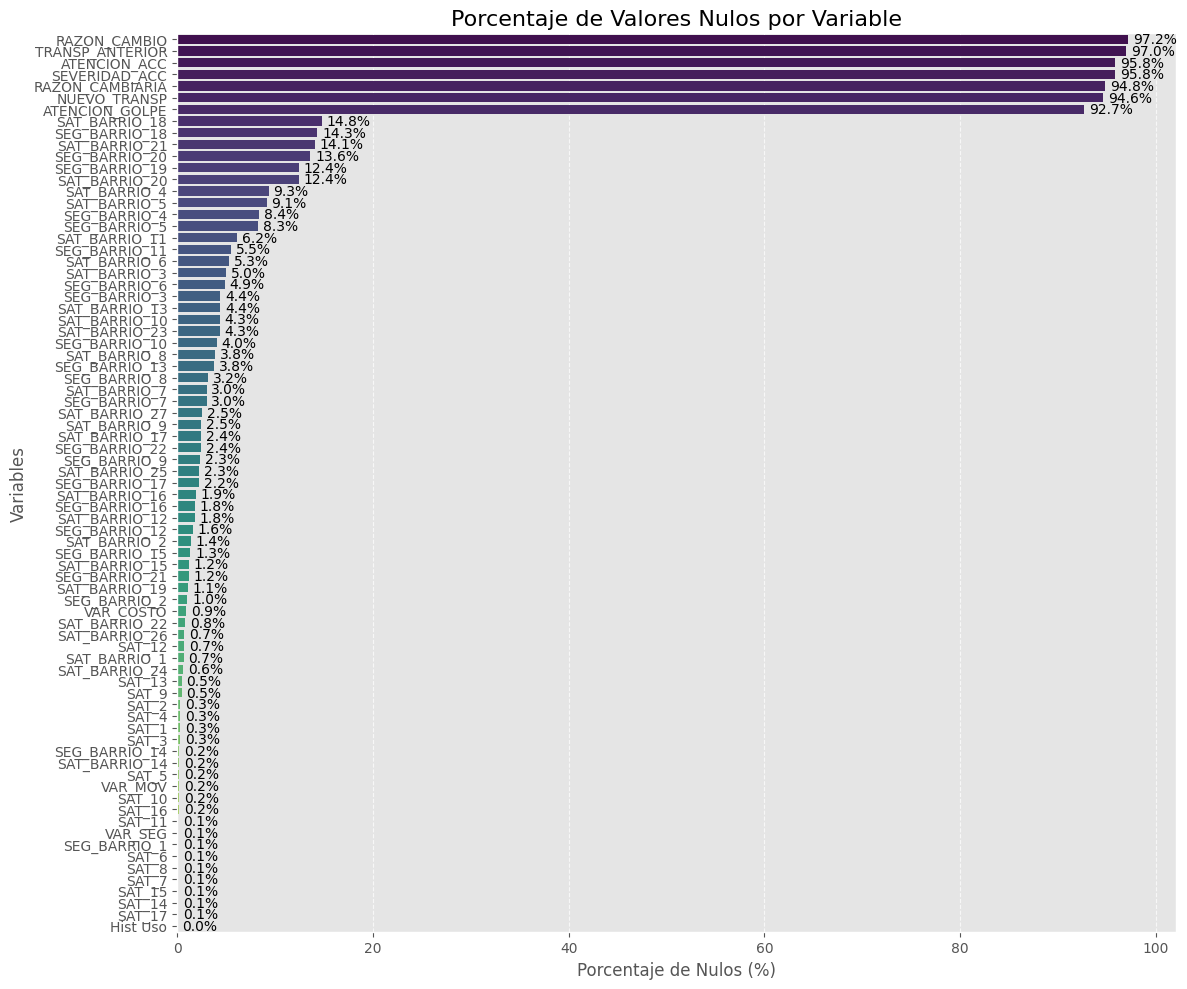

In [133]:
# 1. Calculamos el porcentaje de nulos por columna
null_counts = df.isnull().mean() * 100

# 2. Filtramos solo las que tienen nulos para no saturar el gráfico
# y las ordenamos de mayor a menor
null_counts = null_counts[null_counts > 0].sort_values(ascending=False)

# 3. Configuramos el tamaño del gráfico (largo para que quepan las columnas)
plt.figure(figsize=(12, 10))

# 4. Creamos el gráfico de barras
sns.barplot(x=null_counts.values, y=null_counts.index, palette='viridis')

# 5. Añadimos etiquetas y título
plt.title('Porcentaje de Valores Nulos por Variable', fontsize=16)
plt.xlabel('Porcentaje de Nulos (%)', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Añadimos el valor exacto al lado de cada barra
for i, v in enumerate(null_counts.values):
    plt.text(v + 0.5, i, f'{v:.1f}%', color='black', va='center')

plt.tight_layout()
plt.show()

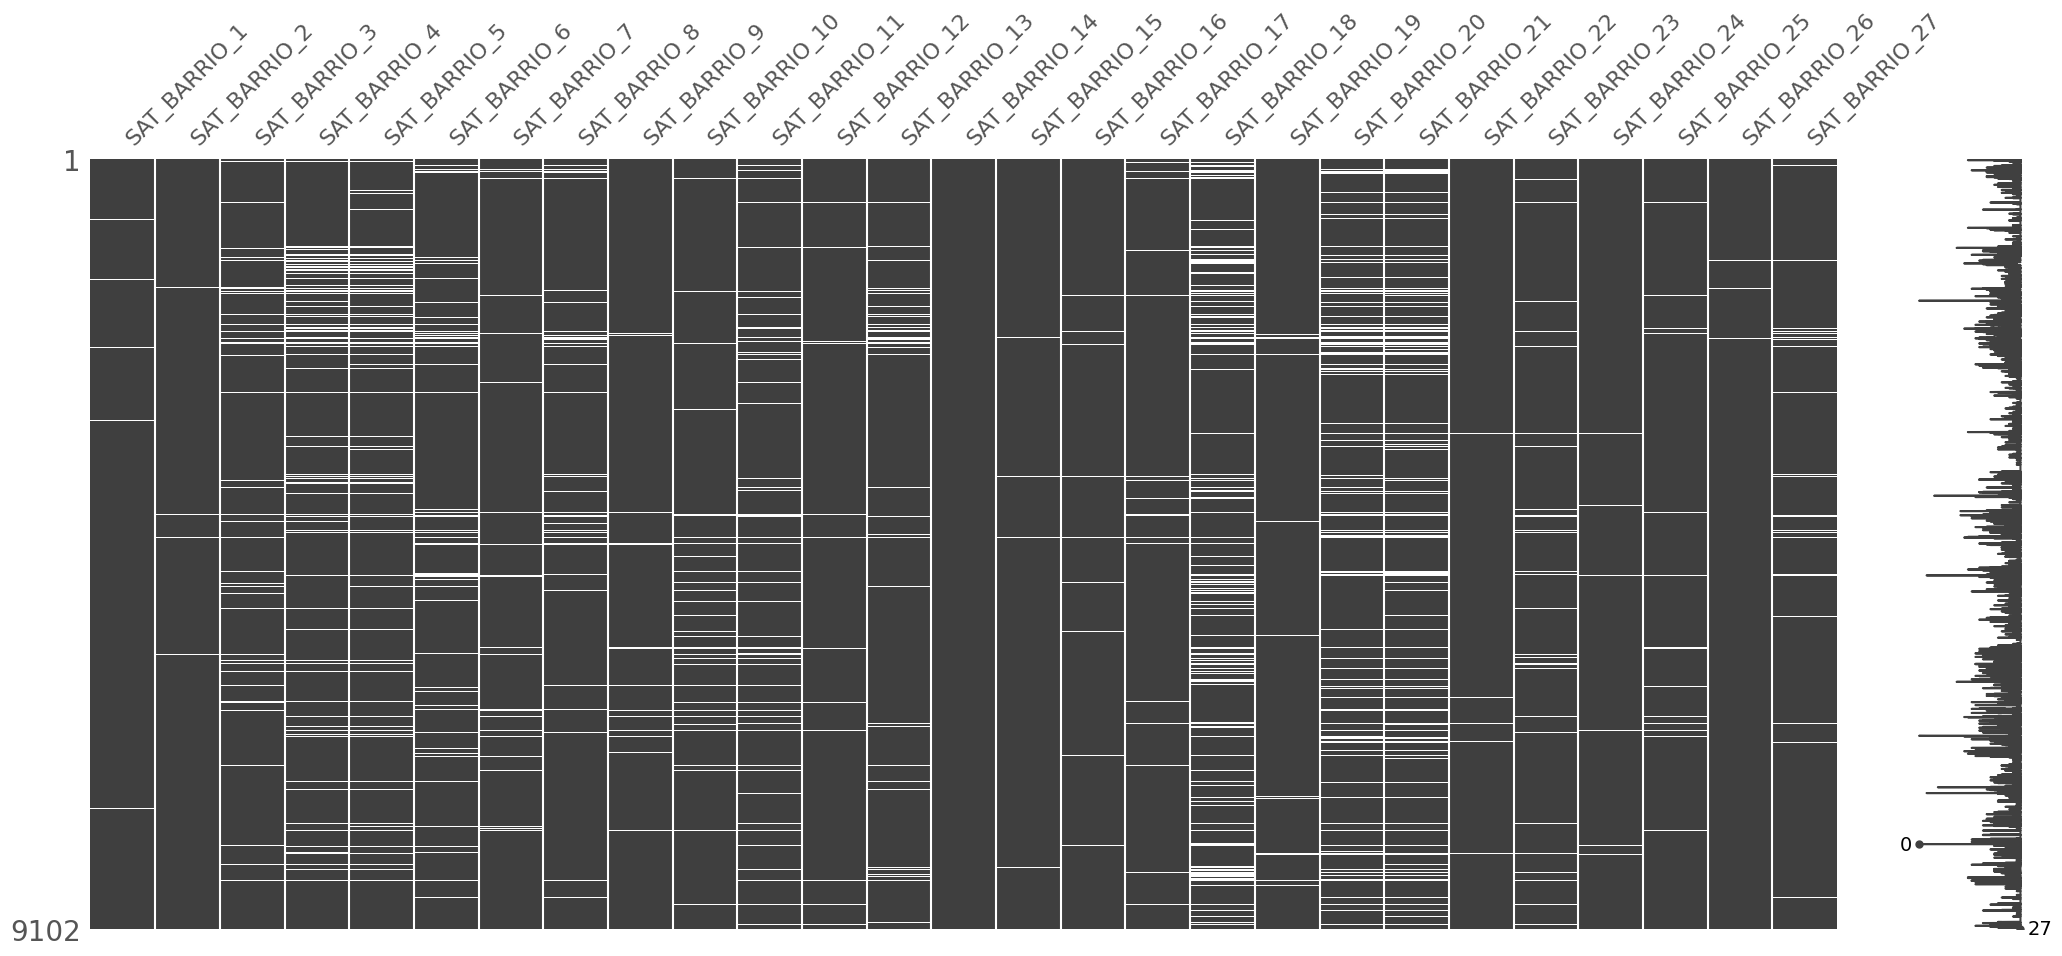

In [134]:
import missingno as msno

# Visualiza la matriz de nulos para ver patrones
# (Tomamos una muestra de las columnas SAT_BARRIO para que sea legible)
cols_sat = [c for c in df.columns if 'SAT_BARRIO' in c]
msno.matrix(df[cols_sat])
plt.show()

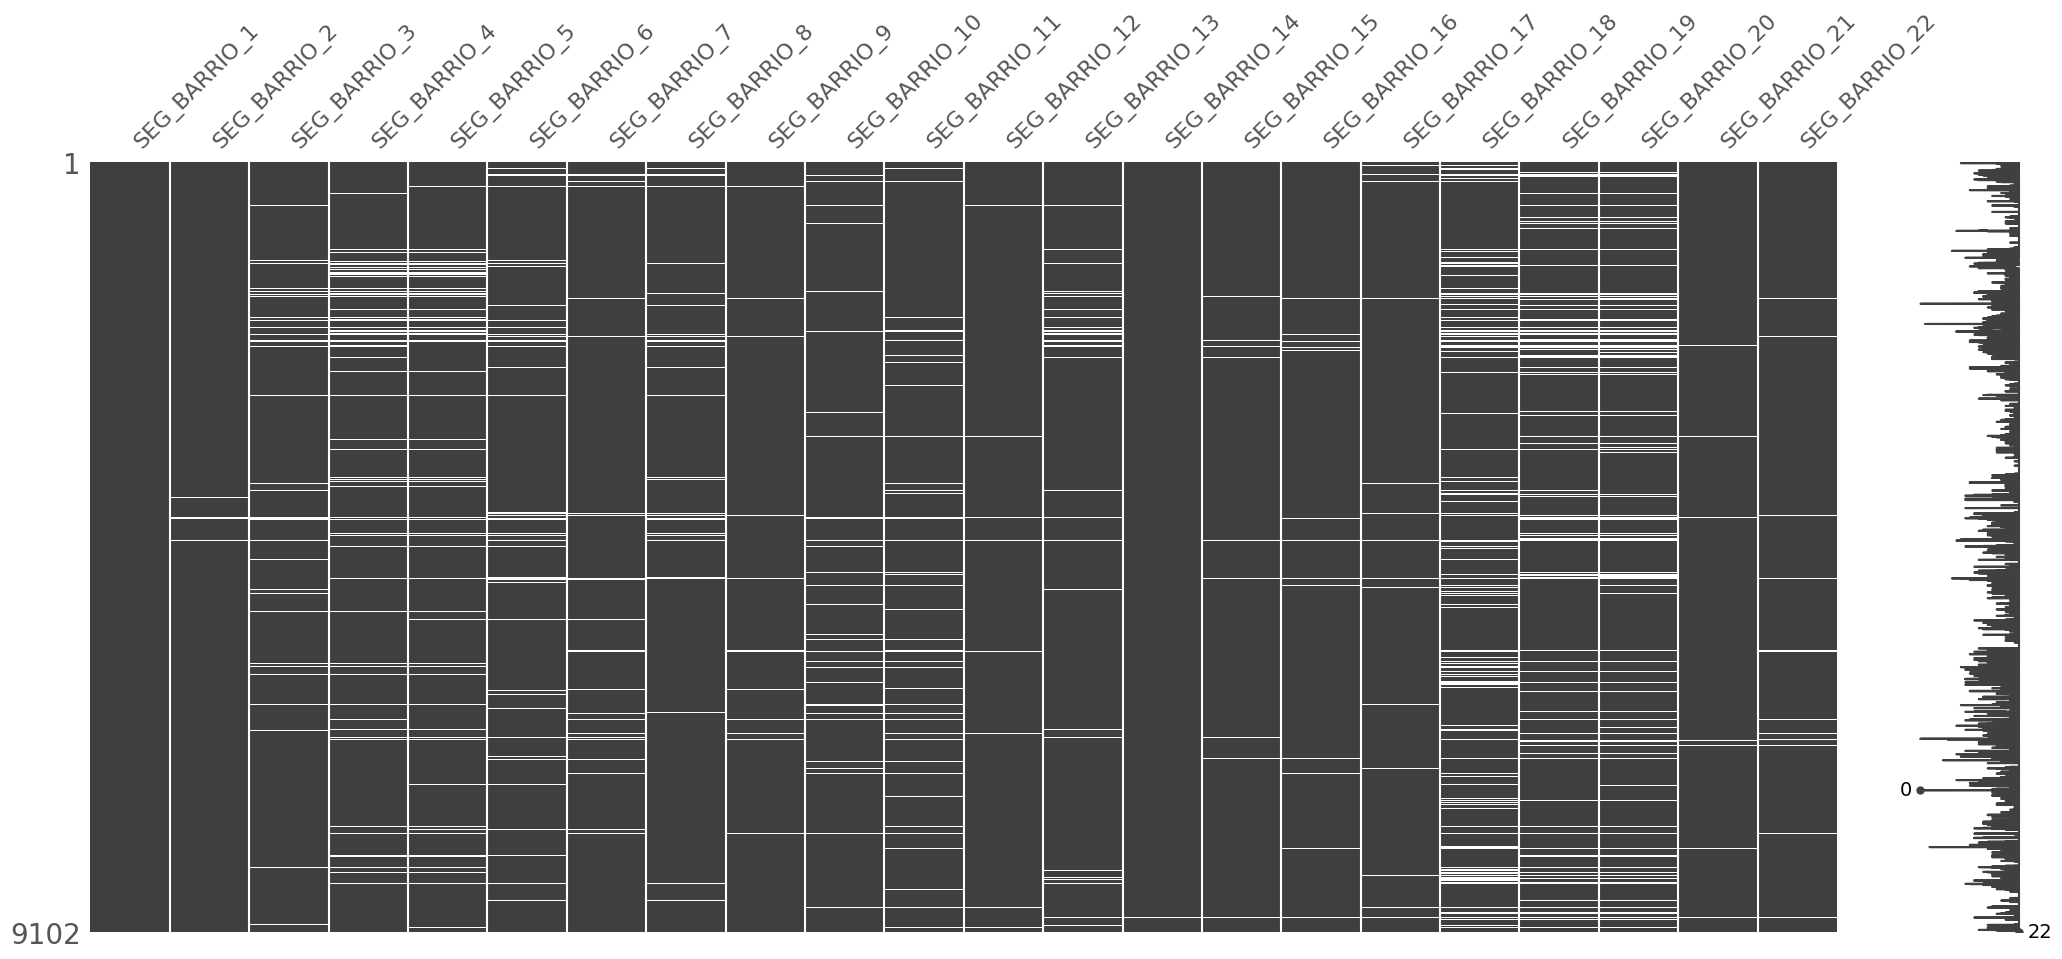

In [135]:
# Visualiza la matriz de nulos para ver patrones
# (Tomamos una muestra de las columnas SAT_BARRIO para que sea legible)
cols_sat = [c for c in df.columns if 'SEG_BARRIO' in c]
msno.matrix(df[cols_sat])
plt.show()

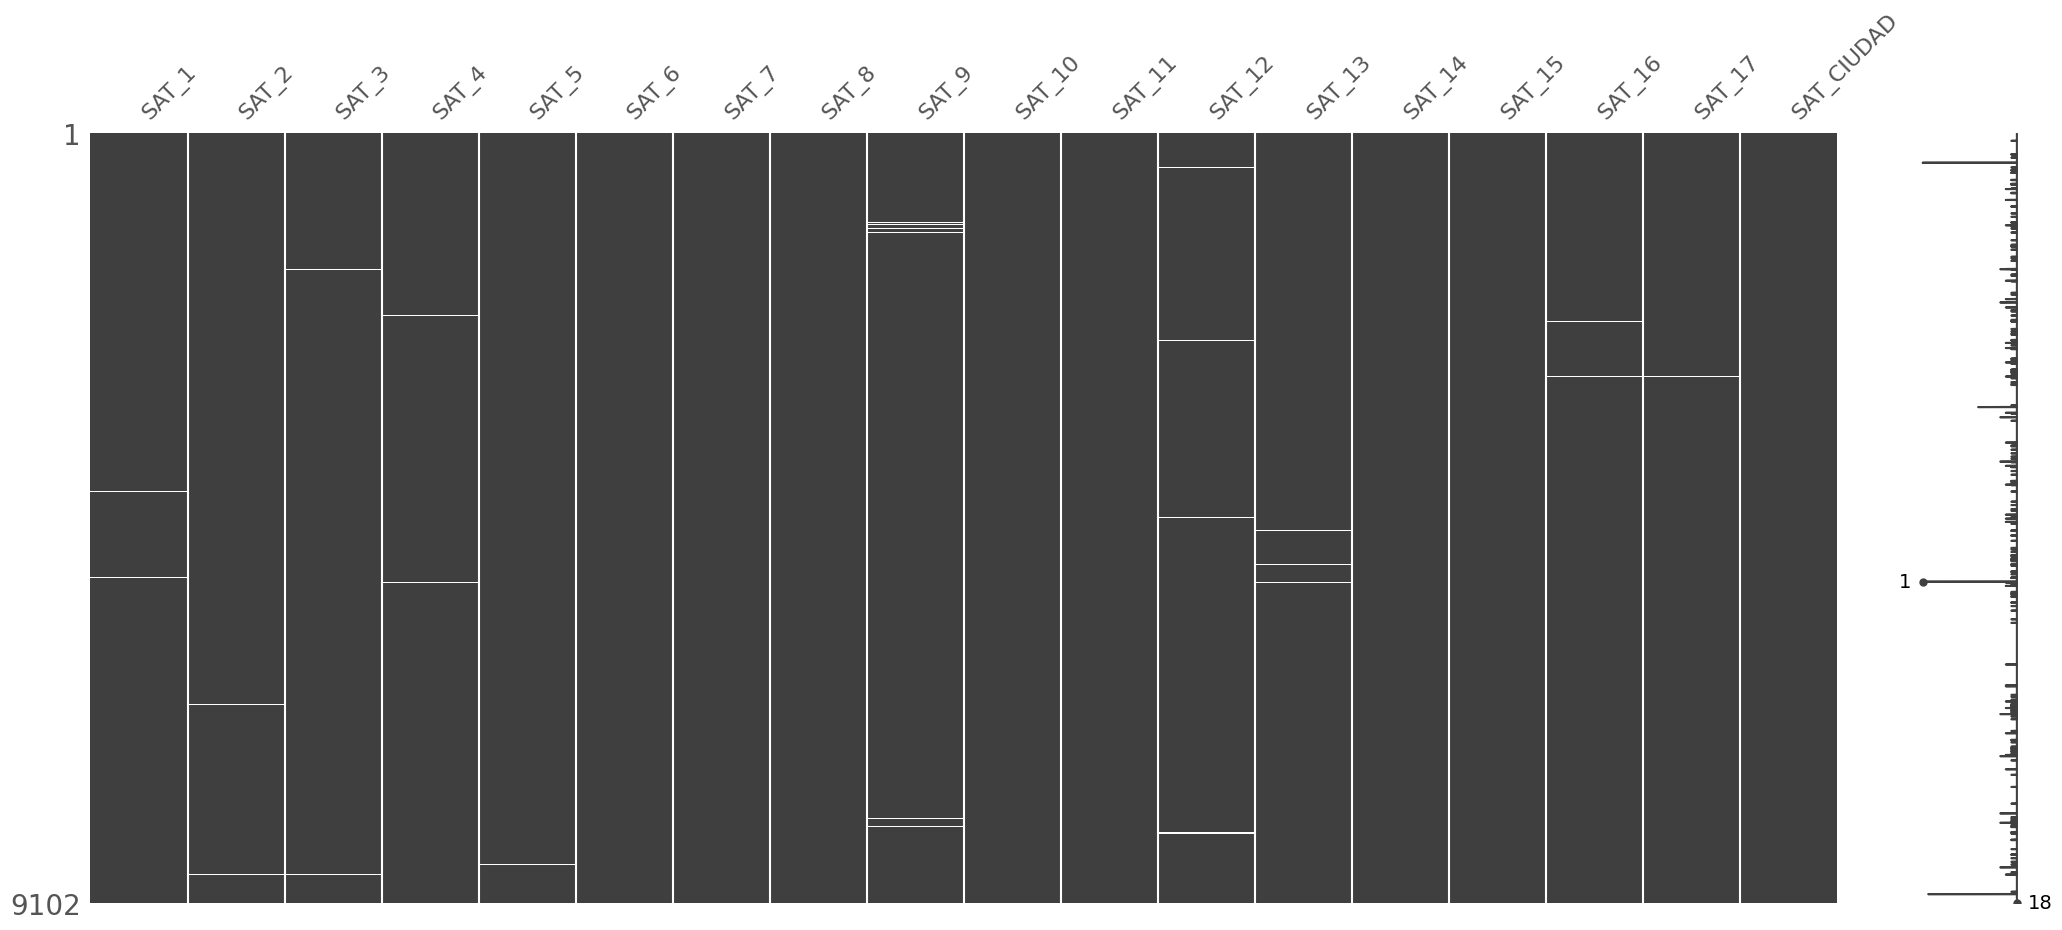

In [136]:
# Usamos 'and' para que cumpla ambas condiciones: que esté 'SAT' pero NO 'BARRIO'
cols_sat_solo = [c for c in df.columns if 'SAT' in c and 'BARRIO' not in c]
msno.matrix(df[cols_sat_solo])
plt.show()

In [137]:
## eliminar variablees con mas de 95% nulos
# 1. Calculamos el porcentaje de nulos por columna (como ya hacías)
null_counts = df.isnull().mean() * 100
cols_a_eliminar = null_counts[null_counts > 90].index

# 2. Eliminamos esas COLUMNAS con demasiados nulos y el ID
df_forimput = df.drop(columns=cols_a_eliminar)
if 'ID' in df_forimput.columns:
    df_forimput = df_forimput.drop(columns=['ID'])
df_forimput.head()


,Localidad,UPL,Loc_may,Transporte_usual,Genero,Edad,Nivel_Educativo,Ocupacion,Factor_Localidad,Factor_UPL,...,SEG_BARRIO_17,SEG_BARRIO_18,SEG_BARRIO_19,SEG_BARRIO_20,SEG_BARRIO_21,SEG_BARRIO_22,CAMBIO_TRANSP,PENSAR_CAMBIO,USO_METRO,VAR_MOVILIDAD
3,1,3,1,4,2,41,4,5,518.739601,775.647171,...,4.0,NaN,4.0,5.0,3.0,NaN,0,0,0,3
8,1,3,1,4,2,25,5,5,422.586518,775.647171,...,4.0,4.0,NaN,NaN,4.0,4.0,0,0,0,2
17,1,3,1,4,2,65,3,4,627.861555,775.647171,...,3.0,NaN,NaN,NaN,NaN,NaN,0,0,1,1
18,1,3,1,2,2,70,3,5,825.482177,775.647171,...,3.0,NaN,NaN,NaN,3.0,3.0,0,0,0,1
23,1,3,1,2,2,27,3,1,422.586518,775.647171,...,4.0,5.0,NaN,NaN,4.0,4.0,0,0,1,2


In [138]:
# 1. Agrupamos tus columnas de interés
cols_sat = [f'SAT_BARRIO_{i}' for i in range(1, 28)]
cols_seg = [f'SEG_BARRIO_{i}' for i in range(1, 23)]
SAT = [f'SAT_{i}' for i in range(1, 18) if f'SAT_{i}' in df.columns]
VAR = ['VAR_COSTO', 'VAR_MOV', 'VAR_SEG']
excluir = set(cols_sat + cols_seg + SAT + VAR + ['ID', 'Localidad', 'Factor_Localidad', 'Factor_UPL'])

Contexto = [c for c in df_forimput.columns if c not in excluir]

df_forimput = df_forimput[cols_sat + cols_seg + SAT + VAR + Contexto]

### Imputacion Copula Gaussiana

**Concepto Clave**

Es una técnica estadística que asume que detrás de tus variables discretas (como una encuesta Likert 1-5) existen variables continuas latentes (invisibles) que siguen una distribución Normal. Separa la "forma" de cada variable de la "relación" entre ellas.⚙️ ¿Cómo funciona? (En 3 pasos)

***Transformación Latente:*** Convierte tus datos originales a una Distribución Normal Estándar ($Z$).

***Imputación:*** Rellena los valores faltantes utilizando la matriz de correlación de estas variables normales (el "esqueleto" de dependencia).

Para un registro con un dato faltante, el modelo usa la matemática de la Distribución Normal Multivariada. Se hace la pregunta:"Dado que sé que $Z_A = 1.5$ y $Z_B = -0.5$, ¿cuál es el valor más probable para $Z_{faltante}$ según mi matriz de correlación?.

El modelo rellena el hueco con un valor numérico continuo (ej. $0.453$).

***Transformación Inversa:*** Devuelve los valores predichos a la escala original, asegurando que respeten los límites (ej. que no salga un 6 o un -1). 
El $0.453$ latente se convierte, por ejemplo, en un 3 en tu escala Likert original.

***Ventaja Principal:*** A diferencia de otros métodos que asumen linealidad directa, la Cópula preserva la estructura de dependencia global de los datos. Es ideal para variables ordinales porque modela la probabilidad conjunta de todas las variables simultáneamente.

In [57]:
df_forimput.shape

(9102, 115)

In [ ]:
#!pip install scipy==1.12.0

In [93]:
from gcimpute.gaussian_copula import GaussianCopula

if not hasattr(np, 'round_'):
    np.round_ = np.round

# 2. Inicializar el modelo de variable latente
# max_iter=20 permite que el algoritmo "dibuje" mejor la campana de Gauss
model = GaussianCopula(max_iter=20)

# 3. Ajustar el modelo
# Aquí el modelo estima los "umbrales" (tau) y la matriz de correlación oculta
X_imputed = model.fit_transform(X=df_forimput.values)

In [94]:
df_latente_ordinal = pd.DataFrame(np.round(X_imputed), columns=df_forimput.columns)

In [ ]:
df_latente_ordinal.head()

,SAT_BARRIO_1,SAT_BARRIO_2,SAT_BARRIO_3,SAT_BARRIO_4,SAT_BARRIO_5,SAT_BARRIO_6,SAT_BARRIO_7,SAT_BARRIO_8,SAT_BARRIO_9,SAT_BARRIO_10,...,SAT_17,VAR_COSTO,VAR_MOV,VAR_SEG,Loc_may,Transporte_usual,Genero,Edad,Nivel_Educativo,Ocupacion
0,4.0,3.0,3.0,4.0,1.0,4.0,3.0,4.0,4.0,2.0,...,4.0,1.0,3.0,4.0,1.0,4.0,2.0,41.0,4.0,5.0
1,4.0,3.0,4.0,3.0,4.0,3.0,3.0,4.0,3.0,4.0,...,4.0,4.0,3.0,4.0,1.0,4.0,2.0,25.0,5.0,5.0
2,3.0,2.0,5.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,4.0,3.0,2.0,1.0,4.0,2.0,65.0,3.0,4.0
3,2.0,3.0,4.0,2.0,1.0,3.0,3.0,2.0,2.0,4.0,...,3.0,1.0,2.0,3.0,1.0,2.0,2.0,70.0,3.0,5.0
4,3.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,4.0,3.0,...,4.0,4.0,3.0,4.0,1.0,2.0,2.0,27.0,3.0,1.0


In [96]:
# 1. Aseguramos que el DF original y el imputado tengan el mismo índice
# Si usaste index=df_forimput.index al crear el DF de imputación, esto será automático.

cols_recuperar = ['ID', 'Localidad', 'Factor_Localidad', 'Factor_UPL', 
'RAZON_CAMBIO', 'TRANSP_ANTERIOR', 'ATENCION_ACC', 'SEVERIDAD_ACC', 'RAZON_CAMBIARIA', 'NUEVO_TRANSP', 'ATENCION_GOLPE']

df.reset_index(drop=True, inplace=True)
df_latente_ordinal.reset_index(drop=True, inplace=True)

# 2. Unimos las columnas originales con el resultado del modelo latente
df_copula = df[cols_recuperar].join(df_latente_ordinal, how='inner')

# 3. Verificamos que no haya nulos en las columnas recuperadas
print("Revisión de columnas recuperadas:")
print(df_copula[cols_recuperar].isnull().sum())
print(f"\nDimensiones finales: {df_copula.shape}")
df_copula.head()

Revisión de columnas recuperadas:
ID                     0
Localidad              0
Factor_Localidad       0
Factor_UPL             0
RAZON_CAMBIO        8844
TRANSP_ANTERIOR     8827
ATENCION_ACC        8719
SEVERIDAD_ACC       8719
RAZON_CAMBIARIA     8627
NUEVO_TRANSP        8610
ATENCION_GOLPE      8436
dtype: int64

Dimensiones finales: (9102, 126)


,ID,Localidad,Factor_Localidad,Factor_UPL,RAZON_CAMBIO,TRANSP_ANTERIOR,ATENCION_ACC,SEVERIDAD_ACC,RAZON_CAMBIARIA,NUEVO_TRANSP,...,CD_VEL_CONDUC,CD_VEL_VEHI,CD_OTRO,GOLPE,ACCIDENTE,SAT_CIUDAD,CAMBIO_TRANSP,PENSAR_CAMBIO,USO_METRO,VAR_MOVILIDAD
0,4,1,518.739601,775.647171,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0
1,9,1,422.586518,775.647171,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0
2,18,1,627.861555,775.647171,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,1.0
3,19,1,825.482177,775.647171,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,24,1,422.586518,775.647171,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,2.0


In [97]:
df_copula.to_excel('C:\\Users\\david\\Downloads\\df_copula.xlsx', index=False)
print("¡Archivo exportado exitosamente!")

¡Archivo exportado exitosamente!


### Imputacion MICE

**Concepto Clave** 

MICE (Multiple Imputation by Chained Equations) es una técnica iterativa que transforma el problema de los datos faltantes en múltiples problemas de predicción. Al usar Random Forest como "motor", el algoritmo no busca líneas rectas o fórmulas simples, sino que utiliza cientos de árboles de decisión para aprender patrones complejos, reglas lógicas y estructuras no lineales en tus datos.

***¿Cómo funciona?***
- **Inicialización:** Rellena preliminarmente los huecos (ej. con la media) para tener una base completa sobre la cual trabajar.
- **Iteración Cíclica:** Selecciona una variable con faltantes como "objetivo" ($Y$) y usa todas las demás como "predictores" ($X$). Entrena un modelo Random Forest para predecir los valores vacíos de esa columna específica.
- **Actualización y Repetición:** Actualiza la columna con las nuevas predicciones y pasa a la siguiente variable. Este ciclo se repite varias veces hasta que los datos se estabilizan (convergen).

***Ventaja Principal***

Su mayor fortaleza es la flexibilidad ante la complejidad. A diferencia de los métodos estadísticos clásicos, MICE con Random Forest captura automáticamente interacciones no lineales (ej. la variable A afecta a la B solo si la C es alta) y maneja perfectamente bases de datos mixtas sin necesidad de normalizar los datos previamente.

In [ ]:
#pip install --upgrade --force-reinstall scipy

In [ ]:
# 1. DEFINICIÓN DE COLUMNAS
cols_likert = cols_sat + cols_seg + SAT + VAR

# 2. CONFIGURAR MICE CON RANDOM FOREST
mice_imputer = IterativeImputer(
    estimator=RandomForestRegressor(
        n_jobs=-1,        # Usa toda la potencia de tu CPU
        random_state=42,  # Resultados reproducibles
        n_estimators=50   # 50 árboles
    ),
    max_iter=10,          # 10 rondas
    random_state=42,
    imputation_order='ascending', # Empieza por las columnas con menos huecos
    min_value=1,  
    max_value=5   
)

print("Iniciando imputación MICE con Random Forest...")

# 3. EJECUCIÓN
matriz_imputada = mice_imputer.fit_transform(df_forimput)

# Recuperamos el DataFrame con los nombres de columnas originales
df_mice = pd.DataFrame(matriz_imputada, columns=df_forimput.columns)

# 4. POST-PROCESAMIENTO
# Aquí forzamos la estructura Likert estricta (Enteros del 1 al 5).

df_mice[cols_likert] = df_mice[cols_likert].round().clip(1, 5)

print("¡Listo! Imputación finalizada.")
print("\nVerificación de nulos restantes:", df_mice.isnull().sum().sum())
print("\nEjemplo de resultados:")
print(df_mice[cols_likert].head())

Iniciando imputación MICE con Random Forest...
¡Listo! Imputación finalizada.

Verificación de nulos restantes: 0

Ejemplo de resultados:
   SAT_BARRIO_1  SAT_BARRIO_2  SAT_BARRIO_3  SAT_BARRIO_4  SAT_BARRIO_5  \
0           4.0           3.0           3.0           4.0           1.0   
1           4.0           3.0           4.0           3.0           4.0   
2           3.0           2.0           5.0           3.0           3.0   
3           2.0           3.0           4.0           2.0           1.0   
4           3.0           3.0           3.0           3.0           3.0   

   SAT_BARRIO_6  SAT_BARRIO_7  SAT_BARRIO_8  SAT_BARRIO_9  SAT_BARRIO_10  ...  \
0           4.0           3.0           4.0           4.0            2.0  ...   
1           3.0           3.0           4.0           3.0            4.0  ...   
2           3.0           3.0           3.0           3.0            3.0  ...   
3           3.0           3.0           2.0           2.0            4.0  ...   
4     

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:867: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [78]:
# 1. Aseguramos que el DF original y el imputado tengan el mismo índice
# Si usaste index=df_forimput.index al crear el DF de imputación, esto será automático.
cols_recuperar = ['ID', 'Localidad', 'Factor_Localidad', 'Factor_UPL', 
'RAZON_CAMBIO', 'TRANSP_ANTERIOR', 'ATENCION_ACC', 'SEVERIDAD_ACC', 'RAZON_CAMBIARIA', 'NUEVO_TRANSP', 'ATENCION_GOLPE']

df.reset_index(drop=True, inplace=True)
df_mice.reset_index(drop=True, inplace=True)

# 2. Unimos las columnas originales con el resultado del modelo latente
df_mice_FINAL = df[cols_recuperar].join(df_mice, how='inner')

# 3. Verificamos que no haya nulos en las columnas recuperadas
print("Revisión de columnas recuperadas:")
print(df_mice_FINAL[cols_recuperar].isnull().sum())
print(f"\nDimensiones finales: {df_mice_FINAL.shape}")
df_mice_FINAL.head()

Revisión de columnas recuperadas:
ID                     0
Localidad              0
Factor_Localidad       0
Factor_UPL             0
RAZON_CAMBIO        8844
TRANSP_ANTERIOR     8827
ATENCION_ACC        8719
SEVERIDAD_ACC       8719
RAZON_CAMBIARIA     8627
NUEVO_TRANSP        8610
ATENCION_GOLPE      8436
dtype: int64

Dimensiones finales: (9102, 126)


,ID,Localidad,Factor_Localidad,Factor_UPL,RAZON_CAMBIO,TRANSP_ANTERIOR,ATENCION_ACC,SEVERIDAD_ACC,RAZON_CAMBIARIA,NUEVO_TRANSP,...,CD_VEL_CONDUC,CD_VEL_VEHI,CD_OTRO,GOLPE,ACCIDENTE,SAT_CIUDAD,CAMBIO_TRANSP,PENSAR_CAMBIO,USO_METRO,VAR_MOVILIDAD
0,4,1,518.739601,775.647171,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0
1,9,1,422.586518,775.647171,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0
2,18,1,627.861555,775.647171,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,1.0
3,19,1,825.482177,775.647171,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,24,1,422.586518,775.647171,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,2.0


In [79]:
df_mice_FINAL.shape

(9102, 126)

In [87]:
# Supongamos que 'Edad' (o cualquier variable que NO tenía nulos) está en ambos dataframes
columna_testigo = 'ID'  # Cambia esto por una variable que pasaste al MICE

# 1. Sacamos la columna del Original (Reseteada)
testigo_original = df[columna_testigo].reset_index(drop=True)

# 2. Sacamos la columna del MICE (Reseteada)
# Asegúrate de que df_mice tenga nombres de columnas, si es numpy array usa el índice de columna
testigo_mice = df_mice_FINAL[columna_testigo].reset_index(drop=True)

# 3. COMPARACIÓN FILA POR FILA
# Esto devuelve True si son idénticos, False si algo se movió
coinciden = (testigo_original == testigo_mice).all()

print(f"¿Las filas están perfectamente alineadas?: {coinciden}")

if not coinciden:
    print("⚠️ ¡PELIGRO! Las filas se desordenaron. NO UNIR.")
    # Ver cuántas fallan
    fallos = (testigo_original != testigo_mice).sum()
    print(f"Número de filas desalineadas: {fallos}")

¿Las filas están perfectamente alineadas?: True


In [89]:
df_mice_FINAL.to_excel('C:\\Users\\david\\Downloads\\df_mice_FINAL.xlsx', index=False)
print("¡Archivo exportado exitosamente!")

¡Archivo exportado exitosamente!


### Evaluar resultados

In [2]:
data_mice = pd.read_excel("C:\\Users\\david\\Downloads\\df_mice_FINAL.xlsx")
#data_mice = pd.read_excel("C:\\Users\\cozabd01\\Downloads\\df_mice_FINAL.xlsx")

data_mice.head()

,ID,Localidad,Factor_Localidad,Factor_UPL,RAZON_CAMBIO,TRANSP_ANTERIOR,ATENCION_ACC,SEVERIDAD_ACC,RAZON_CAMBIARIA,NUEVO_TRANSP,...,CD_VEL_CONDUC,CD_VEL_VEHI,CD_OTRO,GOLPE,ACCIDENTE,SAT_CIUDAD,CAMBIO_TRANSP,PENSAR_CAMBIO,USO_METRO,VAR_MOVILIDAD
0,4,1,518.739601,775.647171,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,4,0,0,0,3
1,9,1,422.586518,775.647171,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,4,0,0,0,2
2,18,1,627.861555,775.647171,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,3,0,0,1,1
3,19,1,825.482177,775.647171,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,1
4,24,1,422.586518,775.647171,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,5,0,0,1,2


In [3]:
data_copula = pd.read_excel("C:\\Users\\david\\Downloads\\df_copula.xlsx")
#data_copula = pd.read_excel("C:\\Users\\cozabd01\\Downloads\\df_copula.xlsx")
data_copula.head()

,ID,Localidad,Factor_Localidad,Factor_UPL,RAZON_CAMBIO,TRANSP_ANTERIOR,ATENCION_ACC,SEVERIDAD_ACC,RAZON_CAMBIARIA,NUEVO_TRANSP,...,CD_VEL_CONDUC,CD_VEL_VEHI,CD_OTRO,GOLPE,ACCIDENTE,SAT_CIUDAD,CAMBIO_TRANSP,PENSAR_CAMBIO,USO_METRO,VAR_MOVILIDAD
0,4,1,518.739601,775.647171,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,4,0,0,0,3
1,9,1,422.586518,775.647171,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,4,0,0,0,2
2,18,1,627.861555,775.647171,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,3,0,0,1,1
3,19,1,825.482177,775.647171,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,1
4,24,1,422.586518,775.647171,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,5,0,0,1,2


In [4]:
df = pd.read_excel("C:\\Users\\david\\Downloads\\Base_Preliminar.xlsx", sheet_name = "Base")
#df = pd.read_excel("C:\\Users\\cozabd01\\Downloads\\Base_Preliminar.xlsx", sheet_name = "Base")
df.head()

,ID,Localidad,UPL,Loc_may,Transporte_usual,Genero,Edad,Nivel_Educativo,Ocupacion,Factor_Localidad,...,SEG_BARRIO_21,SEG_BARRIO_22,CAMBIO_TRANSP,TRANSP_ANTERIOR,RAZON_CAMBIO,PENSAR_CAMBIO,NUEVO_TRANSP,RAZON_CAMBIARIA,USO_METRO,VAR_MOVILIDAD
0,4,1,3,1,4,2,41,4,5,518.739601,...,3.0,NaN,0,NaN,NaN,0,NaN,NaN,0,3
1,9,1,3,1,4,2,25,5,5,422.586518,...,4.0,4.0,0,NaN,NaN,0,NaN,NaN,0,2
2,18,1,3,1,4,2,65,3,4,627.861555,...,NaN,NaN,0,NaN,NaN,0,NaN,NaN,1,1
3,19,1,3,1,2,2,70,3,5,825.482177,...,3.0,3.0,0,NaN,NaN,0,NaN,NaN,0,1
4,24,1,3,1,2,2,27,3,1,422.586518,...,4.0,4.0,0,NaN,NaN,0,NaN,NaN,1,2


#### Distribuciones y relaciones

--- 1. IMPACTO EN VARIABLES NUMÉRICAS ---
Empty DataFrame
Columns: [Orig_Mean, MICE_Diff_Mean%, Copula_Diff_Mean%]
Index: []

--- 2. IMPACTO EN VARIABLES CATEGÓRICAS ---
 Ocupacion: Distribución estable.
 Localidad: Distribución estable.


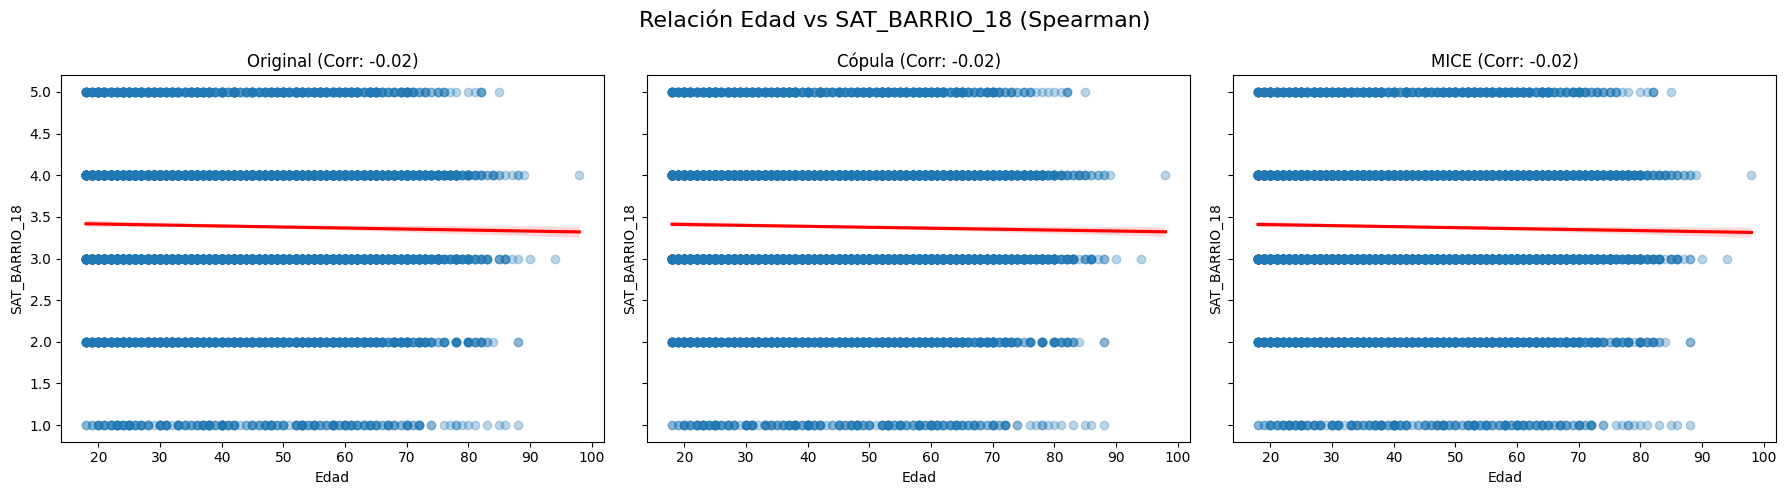

In [5]:
# 1. CONFIGURACIÓN DE VARIABLES
cols_likert = [f'SAT_BARRIO_{i}' for i in range(1, 15)]
cols_demog_num = ['Edad']
cols_demog_cat = ['Ocupacion', 'Nivel_Educacion', 'Transporte_Usual', 'Localidad']

# 2. COMPARACIÓN NUMÉRICA (Likert + Edad)

def comparar_numericas(df_orig, df_copula, df_mice, cols):
    res = pd.DataFrame(index=cols)
    
    res['Orig_Mean'] = df_orig[cols].mean()
    res['Orig_Std'] = df_orig[cols].std()
    
    # MICE
    res['MICE_Mean'] = df_mice[cols].mean()
    res['MICE_Diff_Mean%'] = ((res['MICE_Mean'] - res['Orig_Mean']) / res['Orig_Mean']) * 100
    res['MICE_Std'] = df_mice[cols].std()
    
    # Cópula
    res['Copula_Mean'] = df_copula[cols].mean()
    res['Copula_Diff_Mean%'] = ((res['Copula_Mean'] - res['Orig_Mean']) / res['Orig_Mean']) * 100
    
    return res

print("--- 1. IMPACTO EN VARIABLES NUMÉRICAS ---")

reporte_num = comparar_numericas(df, data_copula, data_mice, cols_likert + cols_demog_num)

filtro_cambios = (abs(reporte_num['MICE_Diff_Mean%']) > 5) | (abs(reporte_num['Copula_Diff_Mean%']) > 5)
print(reporte_num[filtro_cambios][['Orig_Mean', 'MICE_Diff_Mean%', 'Copula_Diff_Mean%']])

# 3. COMPARACIÓN CATEGÓRICA (Frecuencias)
print("\n--- 2. IMPACTO EN VARIABLES CATEGÓRICAS ---")
for col in cols_demog_cat:
    if col in df.columns:
        df_comp = pd.DataFrame({
            'Original': df[col].value_counts(normalize=True),
            'MICE': data_mice[col].value_counts(normalize=True),
            'Copula': data_copula[col].value_counts(normalize=True)
        })
        
        max_diff = (df_comp['Original'] - df_comp['MICE']).abs().max()
        
        if max_diff > 0.05: # Si cambia más de un 5%
            print(f" {col}: Cambios notables en distribución (Max Diff: {max_diff:.1%})")
            print(df_comp.head(3)) # Muestra las top 3 categorías
        else:
            print(f" {col}: Distribución estable.")

# 4. GRÁFICOS DE RELACIÓN (Edad vs Satisfacción)
# Tomamos SAT_BARRIO_1 como ejemplo clave
var_target = 'SAT_BARRIO_18' 

if var_target in df.columns and 'Edad' in df.columns:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    fig.suptitle(f'Relación Edad vs {var_target} (Spearman)', fontsize=16)
    
    # Original
    sns.regplot(x='Edad', y=var_target, data=df, ax=axes[0], scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    corr_o = df[['Edad', var_target]].corr(method='spearman').iloc[0,1]
    axes[0].set_title(f"Original (Corr: {corr_o:.2f})")
    
    # Copula
    sns.regplot(x='Edad', y=var_target, data=data_copula, ax=axes[1], scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    corr_c = data_copula[['Edad', var_target]].corr(method='spearman').iloc[0,1]
    axes[1].set_title(f"Cópula (Corr: {corr_c:.2f})")
    
    # MICE
    sns.regplot(x='Edad', y=var_target, data=data_mice, ax=axes[2], scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    corr_m = data_mice[['Edad', var_target]].corr(method='spearman').iloc[0,1]
    axes[2].set_title(f"MICE (Corr: {corr_m:.2f})")
    
    plt.tight_layout()
    plt.show()

La imagen revela una preservación excepcional de la estructura de datos tras el proceso de imputación, ya que tanto el modelo de Cópula como MICE replican con exactitud la correlación de Spearman original de -0.02. Visualmente, se mantiene el efecto de "persiana" característico de las variables ordinales tipo Likert, lo que confirma que no se introdujo ruido ni valores decimales fuera de rango que desdibujaran la naturaleza discreta de la variable SAT_BARRIO_18. La estabilidad de la línea de regresión (casi horizontal en los tres paneles) demuestra que los valores faltantes fueron reconstruidos respetando la independencia estadística entre la edad y la satisfacción, validando así que ninguno de los métodos de imputación sesgó la relación hacia una tendencia inexistente

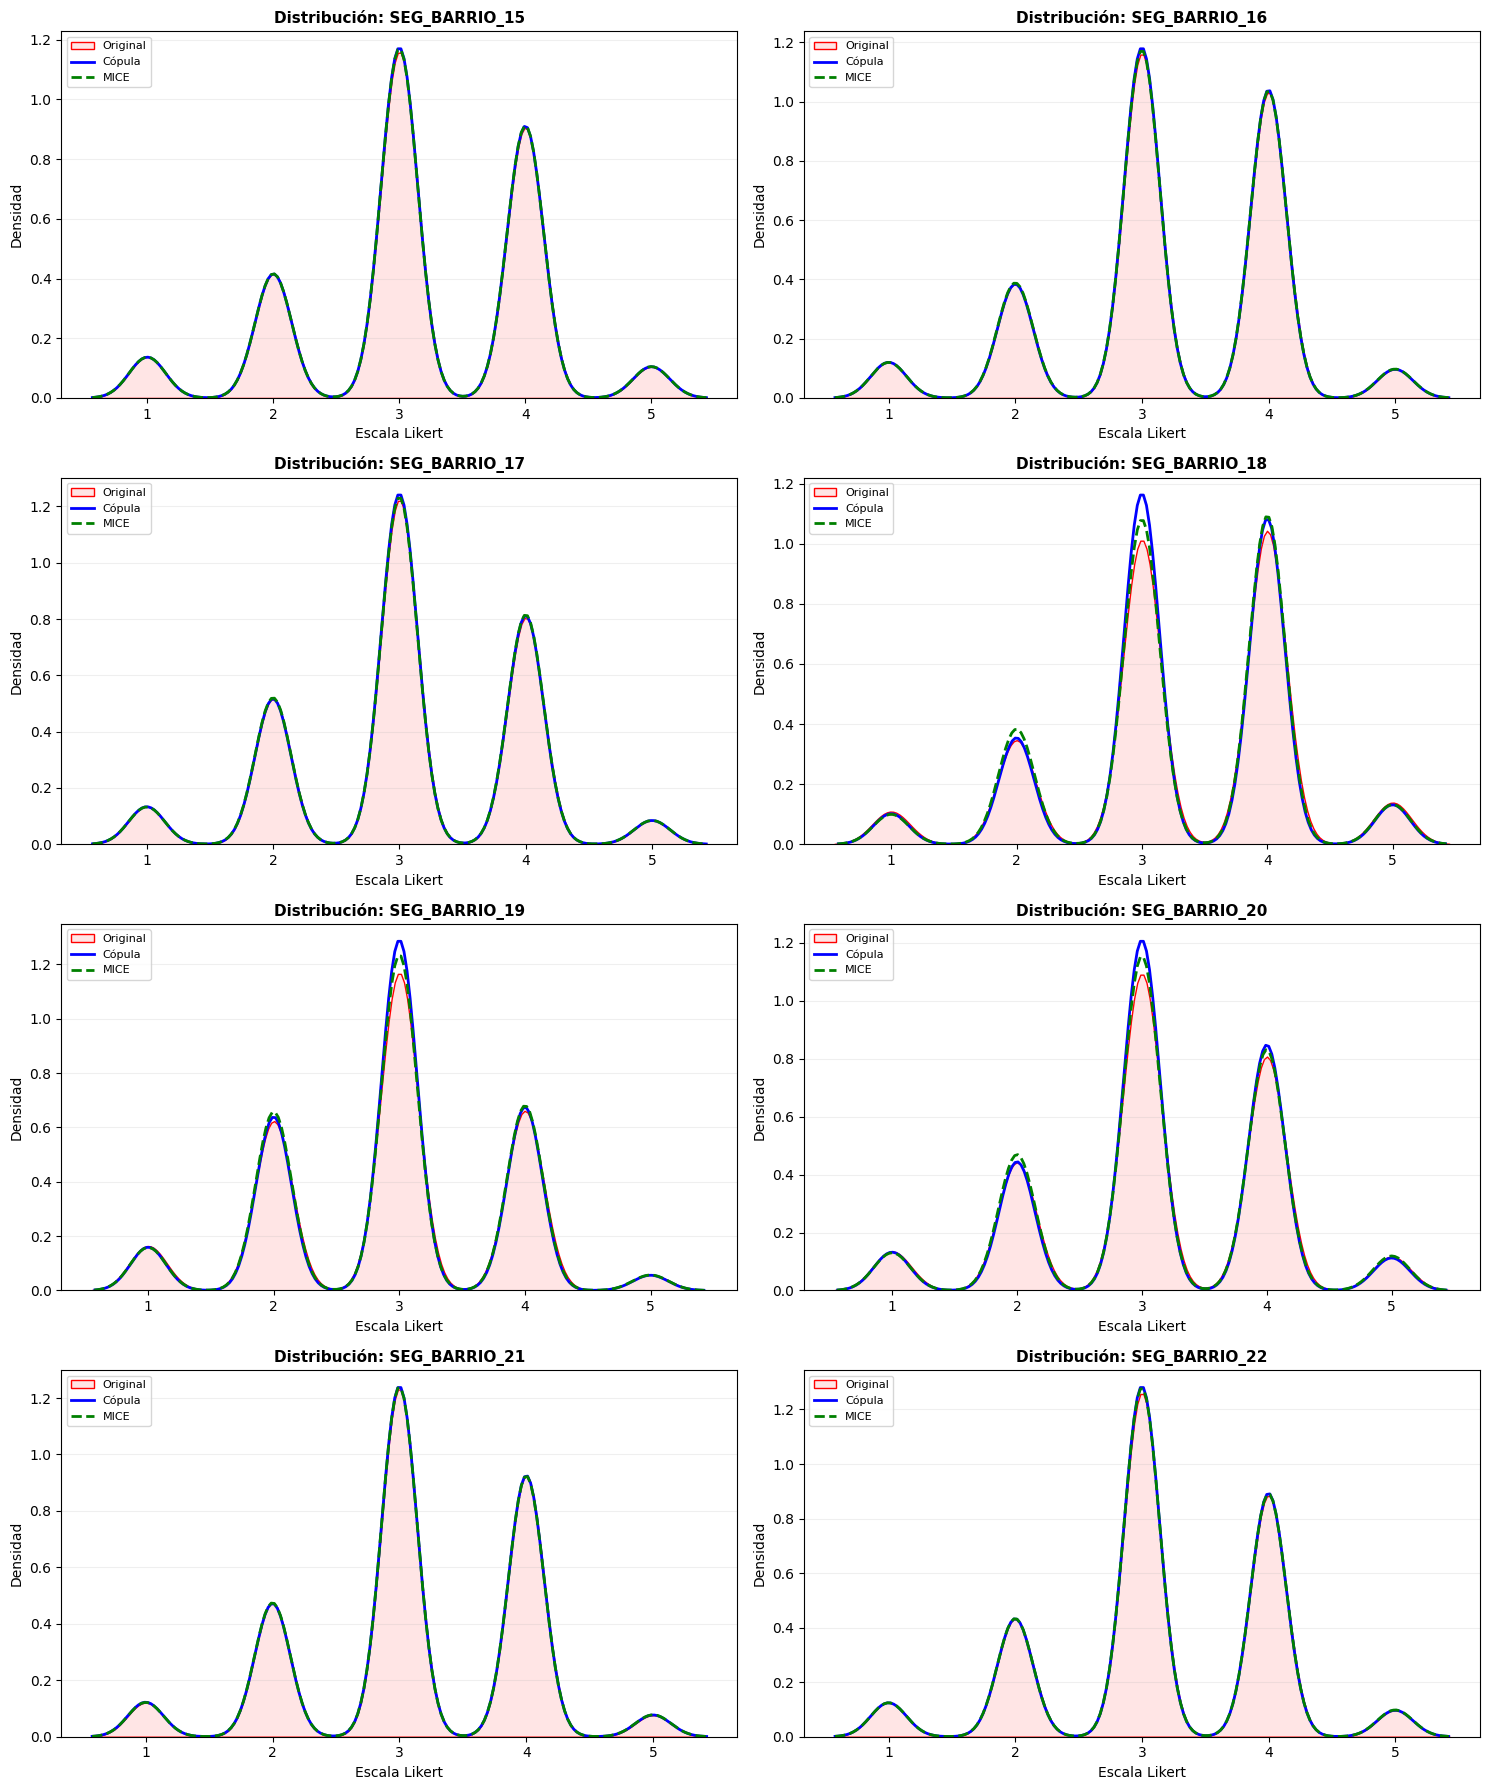

In [6]:
# Configuración de variables
cols = [f'SEG_BARRIO_{i}' for i in range(15, 23)]
fig, axes = plt.subplots(4, 2, figsize=(15, 18))
axes = axes.flatten()

for i, col in enumerate(cols):
    ax = axes[i]
    
    # Graficamos las tres versiones (Original, Cópula y MICE)
    sns.kdeplot(df[col].dropna(), ax=ax, label='Original', color='red', fill=True, alpha=0.1)
    sns.kdeplot(data_copula[col], ax=ax, label='Cópula', color='blue', lw=2)
    sns.kdeplot(data_mice[col],   ax=ax, label='MICE',   color='green', ls='--', lw=2)

    # Estética rápida
    ax.set_title(f'Distribución: {col}', fontsize=11, fontweight='bold')
    ax.set(xlabel='Escala Likert', ylabel='Densidad')
    ax.legend(fontsize=8, loc='upper left')
    ax.grid(axis='y', alpha=0.2)

plt.tight_layout()
plt.show()

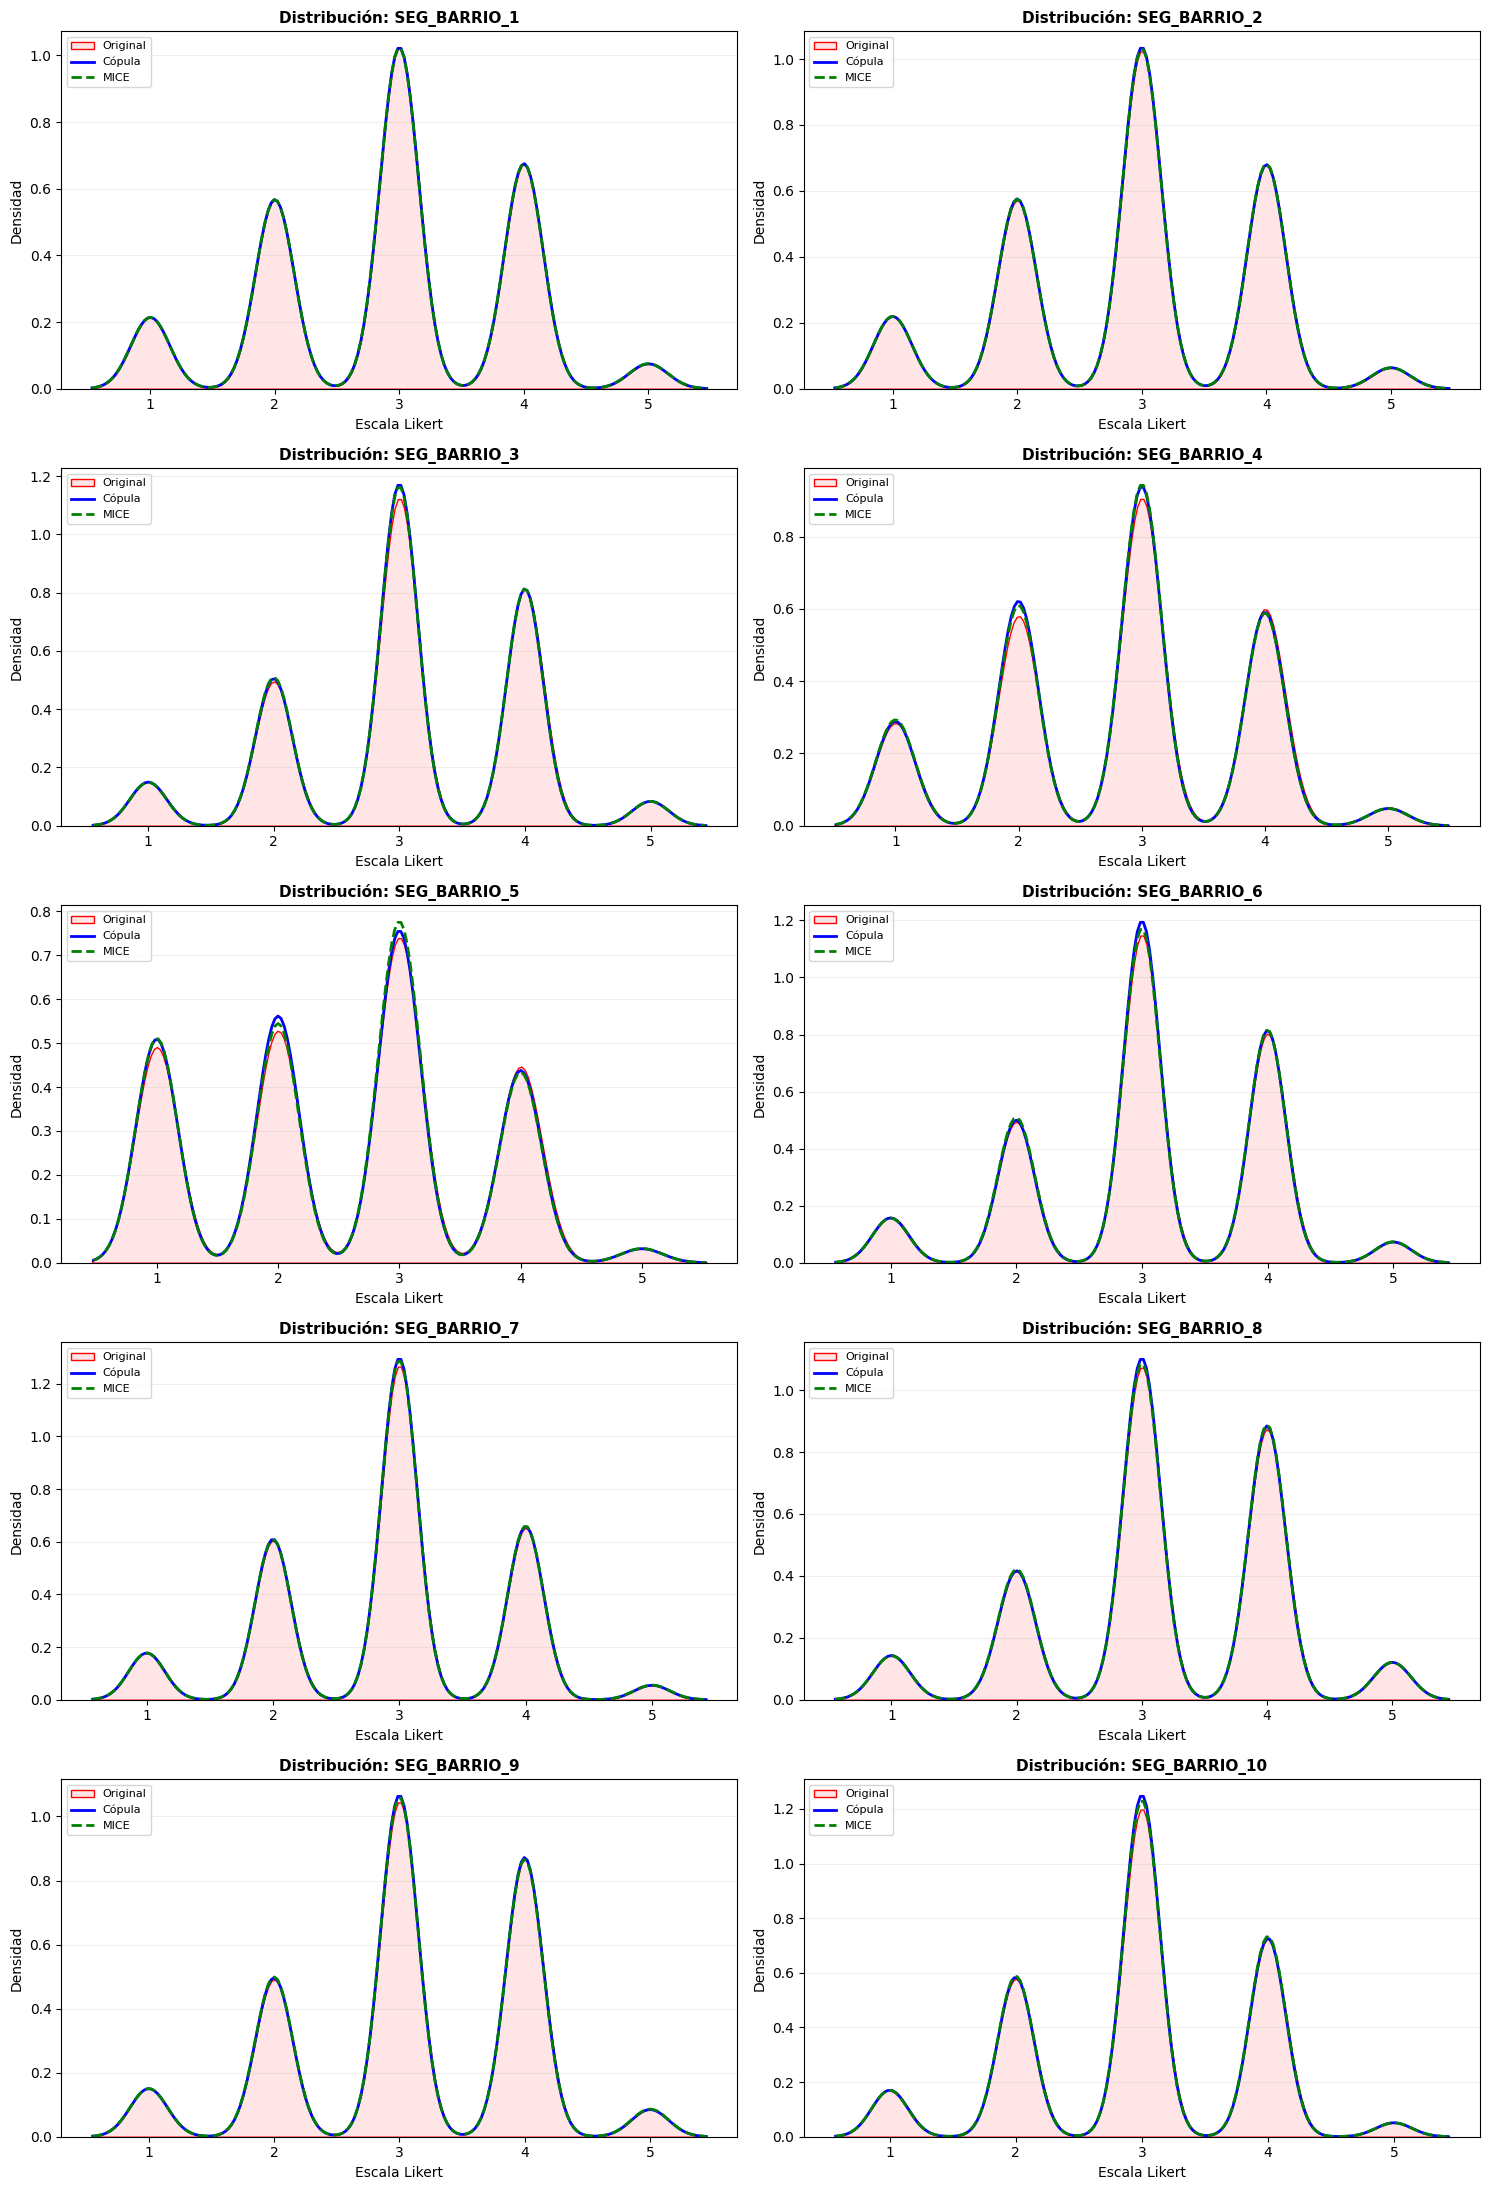

In [7]:
# Configuración de variables (10 columnas)
cols = [f'SEG_BARRIO_{i}' for i in range(1, 11)]
fig, axes = plt.subplots(5, 2, figsize=(15, 22))
axes = axes.flatten()

for i, col in enumerate(cols):
    ax = axes[i]
    if col not in df.columns: continue

    # Comparativa de Distribuciones
    sns.kdeplot(df[col].dropna(), ax=ax, label='Original', color='red', fill=True, alpha=0.1)
    sns.kdeplot(data_copula[col], ax=ax, label='Cópula',   color='blue', lw=2)
    sns.kdeplot(data_mice[col],   ax=ax, label='MICE',     color='green', ls='--', lw=2)

    # Estética refinada
    ax.set_title(f'Distribución: {col}', fontsize=11, fontweight='bold')
    ax.set(xlabel='Escala Likert', ylabel='Densidad')
    ax.legend(fontsize=8, loc='upper left')
    ax.grid(axis='y', alpha=0.2)

plt.tight_layout()
plt.show()

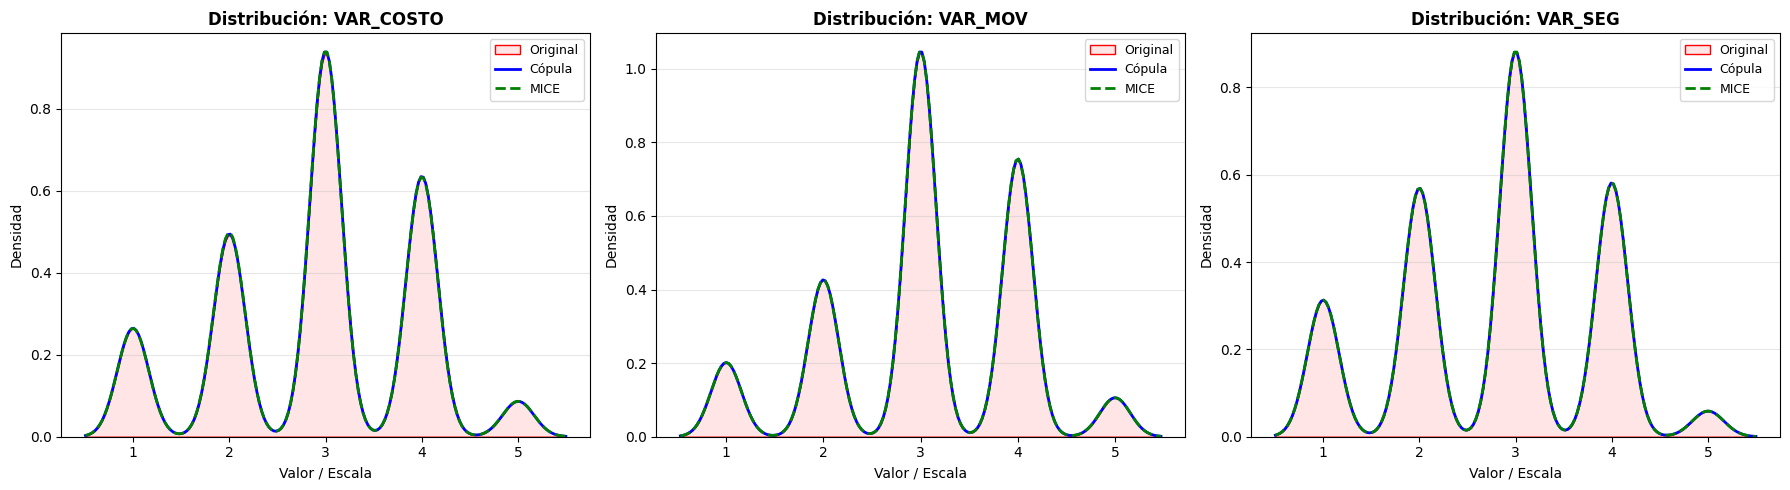

In [8]:
# Variables a comparar
cols = ['VAR_COSTO', 'VAR_MOV', 'VAR_SEG']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(cols):
    ax = axes[i]
    if col not in df.columns: continue

    # Gráficos de densidad
    sns.kdeplot(df[col].dropna(), ax=ax, label='Original', color='red', fill=True, alpha=0.1)
    sns.kdeplot(data_copula[col], ax=ax, label='Cópula',   color='blue',  lw=2)
    sns.kdeplot(data_mice[col],   ax=ax, label='MICE',     color='green', lw=2, ls='--')

    # Estética del panel
    ax.set_title(f'Distribución: {col}', fontsize=12, fontweight='bold')
    ax.set(xlabel='Valor / Escala', ylabel='Densidad')
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Los gráficos de densidad revelan una coincidencia casi total entre las tres bases de datos, lo que confirma que el proceso de imputación fue sumamente respetuoso con la información original. En todas las variables de SEG_BARRIO y VAR_, las curvas de la Cópula (azul) y MICE (verde punteada) se superponen bien sobre la distribución Original (roja), manteniendo intactos los cinco niveles de la escala Likert. Esta simetría visual demuestra que ninguno de los métodos alteró la frecuencia de las respuestas ni desplazó los promedios, logrando rellenar los valores faltantes preservando la naturaleza discreta y la variabilidad de cada pregunta.

#### Correlaciones

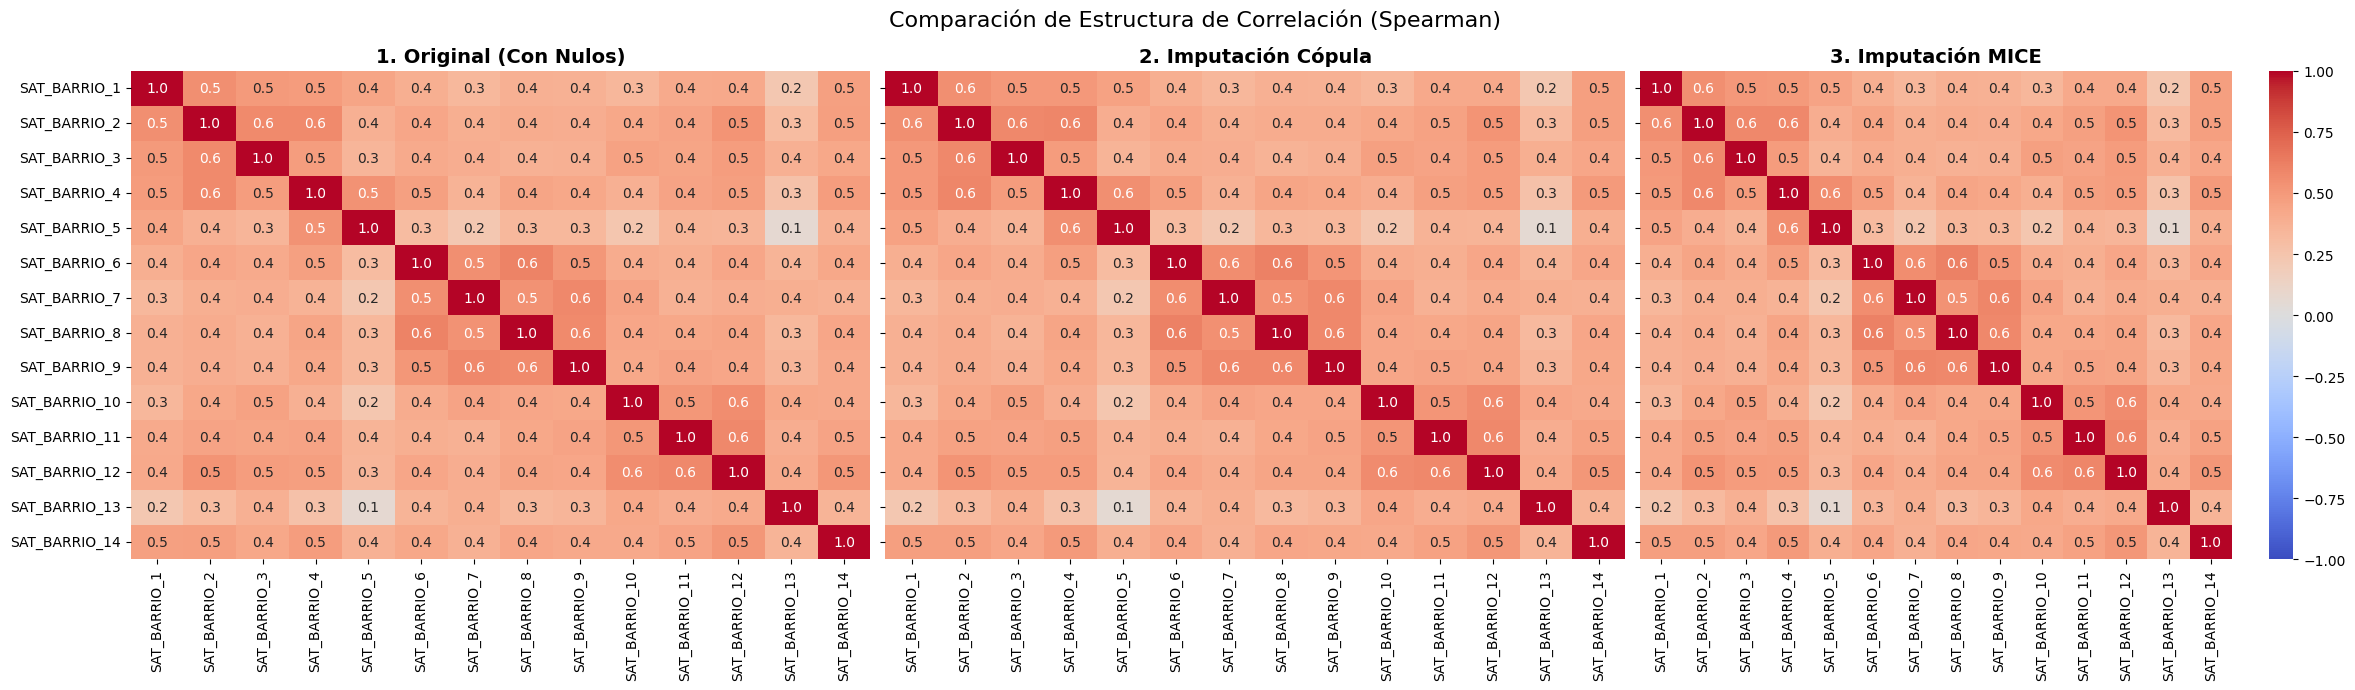

In [9]:
# 1. Configuración de datos
cols = [f'SAT_BARRIO_{i}' for i in range(1, 15)]
datasets = [
    (df, '1. Original (Con Nulos)'),
    (data_copula, '2. Imputación Cópula'),
    (data_mice, '3. Imputación MICE')
]

# 2. Configuración de la figura
fig, axes = plt.subplots(1, 3, figsize=(24, 7), sharey=True)
fig.suptitle('Comparación de Estructura de Correlación (Spearman)', fontsize=16)

# 3. Generación automática de gráficos
for i, (data, title) in enumerate(datasets):
    # Calculamos la matriz
    corr = data[cols].corr(method='spearman')
    
    # Graficamos (Barra de color solo en el último gráfico para limpieza visual)
    sns.heatmap(corr, ax=axes[i], annot=True, fmt=".1f", 
                cmap='coolwarm', vmin=-1, vmax=1, cbar=(i == 2))
    
    axes[i].set_title(title, fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Numéricamente, las variaciones son mínimas (diferencias de apenas 0.0 a 0.1), observándose en algunos casos un ligero y esperado fortalecimiento de la relación en los datos imputados (por ejemplo, entre SAT_BARRIO_1 y SAT_BARRIO_2, que pasa de 0.5 a 0.6), validando que ni la Cópula ni MICE introdujeron sesgos o distorsiones artificiales en las interacciones entre variables

In [10]:
# cols_likert = cols_sat + cols_seg + SAT + VAR
# likert_df = df[cols_likert]
# likert_copula = data_copula[cols_likert]
# likert_mice = data_mice[cols_likert]
### CORRELACION POLICORICA EN R

### Conclusión

La elección de MICE con Random Forest se justifica por su capacidad demostrada para reconstruir la información faltante respetando la naturaleza no lineal y discreta de las variables. La evidencia gráfica confirma que este método replicó las distribuciones originales (picos y valles en las escalas Likert) y mantuvo intacta la estructura de correlaciones, validando que el algoritmo de árboles de decisión logró capturar la complejidad de los patrones subyacentes sin introducir sesgos ni distorsiones matemáticas, lo que garantiza la máxima fiabilidad para los análisis posteriores de la investigación. Adicional, en variables con arta cantidad de nulos como SEG_BARRIO_18, se evidencia que preservó de mejor manera la distribución de la variable

## AFE

In [11]:
## Dividir base de datos por constructo
cols_barriosat = [f'SAT_BARRIO_{i}' for i in range(1, 28) if f'SAT_BARRIO_{i}' in df.columns]
cols_barrioseg = [f'SEG_BARRIO_{i}' for i in range(1, 23) if f'SEG_BARRIO_{i}' in df.columns]
cols_sat = [f'SAT_{i}' for i in range(1, 18) if f'SAT_{i}' in df.columns]
cols_seg = [f'SEG_{i}' for i in range(1, 4) if f'SEG_{i}' in df.columns]

df_sat_barrio = data_mice[cols_barriosat]
df_seg_barrio = data_mice[cols_barrioseg]
df_sat = data_mice[cols_sat]
df_seg = data_mice[cols_seg]

## Imprimir nombres de columnas
print("Columnas SAT_BARRIO:")
print(df_sat_barrio.columns.tolist())

print("\nColumnas SEG_BARRIO:")
print(df_seg_barrio.columns.tolist())

print("\nColumnas SAT:")
print(df_sat.columns.tolist())

print("\nColumnas SEG:")
print(df_seg.columns.tolist())

Columnas SAT_BARRIO:
['SAT_BARRIO_1', 'SAT_BARRIO_2', 'SAT_BARRIO_3', 'SAT_BARRIO_4', 'SAT_BARRIO_5', 'SAT_BARRIO_6', 'SAT_BARRIO_7', 'SAT_BARRIO_8', 'SAT_BARRIO_9', 'SAT_BARRIO_10', 'SAT_BARRIO_11', 'SAT_BARRIO_12', 'SAT_BARRIO_13', 'SAT_BARRIO_14', 'SAT_BARRIO_15', 'SAT_BARRIO_16', 'SAT_BARRIO_17', 'SAT_BARRIO_18', 'SAT_BARRIO_19', 'SAT_BARRIO_20', 'SAT_BARRIO_21', 'SAT_BARRIO_22', 'SAT_BARRIO_23', 'SAT_BARRIO_24', 'SAT_BARRIO_25', 'SAT_BARRIO_26', 'SAT_BARRIO_27']

Columnas SEG_BARRIO:
['SEG_BARRIO_1', 'SEG_BARRIO_2', 'SEG_BARRIO_3', 'SEG_BARRIO_4', 'SEG_BARRIO_5', 'SEG_BARRIO_6', 'SEG_BARRIO_7', 'SEG_BARRIO_8', 'SEG_BARRIO_9', 'SEG_BARRIO_10', 'SEG_BARRIO_11', 'SEG_BARRIO_12', 'SEG_BARRIO_13', 'SEG_BARRIO_14', 'SEG_BARRIO_15', 'SEG_BARRIO_16', 'SEG_BARRIO_17', 'SEG_BARRIO_18', 'SEG_BARRIO_19', 'SEG_BARRIO_20', 'SEG_BARRIO_21', 'SEG_BARRIO_22']

Columnas SAT:
['SAT_1', 'SAT_2', 'SAT_3', 'SAT_4', 'SAT_5', 'SAT_6', 'SAT_7', 'SAT_8', 'SAT_9', 'SAT_10', 'SAT_11', 'SAT_12', 'SAT_13', 'SA

**Prueba de Esfericidad de Bartlett**
¿Existe alguna relación entre mis variables o son totalmente independientes?
$$\chi^2 = - \left( n - 1 - \frac{2p + 5}{6} \right) \times \ln(|R|)$$

- $n$ (Tamaño de la muestra)
- $p$ (Número de variables)
- $|R|$ (El Determinante): Es el determinante de tu matriz de correlación.
- $\ln$: El logaritmo natural.

**KMO (Kaiser-Meyer-Olkin)**
¿Qué tan fuerte es la cohesión entre las variables para formar grupos?

Compara la magnitud de los coeficientes de correlación observados con la magnitud de los coeficientes de correlación parcial.
$$KMO = \frac{\text{Correlaciones Observadas}}{\text{Correlaciones Observadas} + \text{Correlaciones Parciales}}$$

In [14]:
# Definir las bases de datos
dfs = {"SAT_BARRIO": df_sat_barrio, "SEG_BARRIO": df_seg_barrio, 
       "SAT_GENERAL": df_sat, "SEG_GENERAL": df_seg}

print(f"{'BASE':<15} | {'p-BARTLETT':<10} | {'KMO':<6} | {'¿SIRVE?'}")
print("-" * 50)

for name, df in dfs.items():
    _, p_val = calculate_bartlett_sphericity(df)
    _, kmo_val = calculate_kmo(df)

    
    print(f"{name:<15} | {p_val:.4f}     | {kmo_val:.3f} | {'SI' if (p_val < 0.05 and kmo_val > 0.6) else 'NO'}")

BASE            | p-BARTLETT | KMO    | ¿SIRVE?
--------------------------------------------------
SAT_BARRIO      | 0.0000     | 0.964 | SI
SEG_BARRIO      | 0.0000     | 0.968 | SI
SAT_GENERAL     | 0.0000     | 0.942 | SI
SEG_GENERAL     | 0.0000     | 0.668 | SI


El análisis de viabilidad confirmó la pertinencia de los datos para someterse a un análisis factorial. La prueba de esfericidad de Bartlett resultó estadísticamente significativa en las cuatro sub-bases ($p < .001$), lo que permite rechazar la hipótesis de independencia y confirma la existencia de correlaciones subyacentes entre las variables. 

Respecto a la adecuación muestral, el índice KMO reveló una estructura interna excepcionalmente sólida para las dimensiones de Satisfacción de Barrio, Seguridad de Barrio y Satisfacción General, con valores superiores a 0.94 (clasificados como meritorios). Aunque la dimensión de Seguridad General presentó un coeficiente más moderado (0.668), este supera el umbral mínimo de 0.60, validando así la factibilidad técnica para proceder con la extracción de factores en la totalidad del modelo.

In [13]:
#!pip install factor-analyzer==0.5.0 scikit-learn==1.3.0 --- INCOMPATBILIDAD DE VERSIONES


ANALIZANDO NÚMERO DE FACTORES: SAT_BARRIO
-> Criterio de Kaiser sugiere: 4 factores
-> Autovalores primeros 5: [11.15, 1.72, 1.47, 1.25, 0.79]


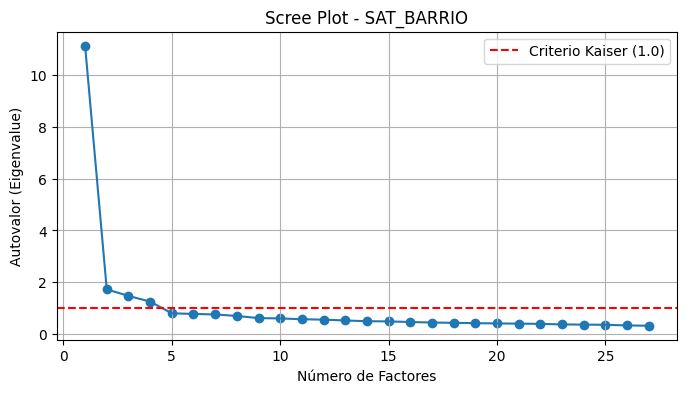


ANALIZANDO NÚMERO DE FACTORES: SEG_BARRIO
-> Criterio de Kaiser sugiere: 2 factores
-> Autovalores primeros 5: [10.83, 1.67, 0.96, 0.9, 0.66]


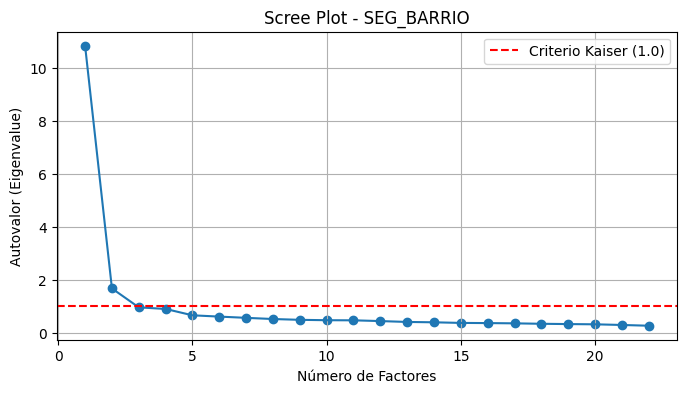


ANALIZANDO NÚMERO DE FACTORES: SAT_GENERAL
-> Criterio de Kaiser sugiere: 2 factores
-> Autovalores primeros 5: [6.63, 1.55, 0.9, 0.81, 0.73]


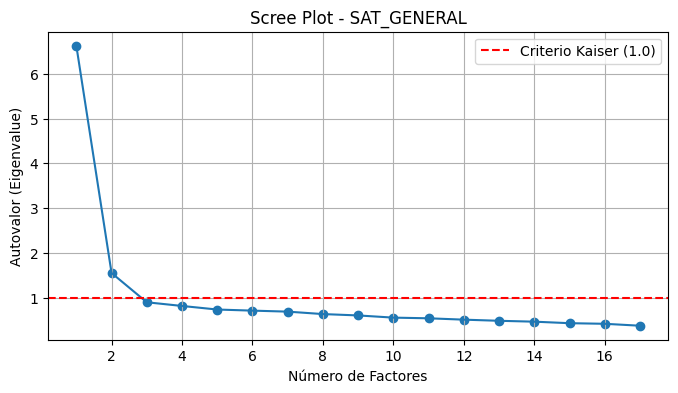


ANALIZANDO NÚMERO DE FACTORES: SEG_GENERAL
-> Criterio de Kaiser sugiere: 1 factores
-> Autovalores primeros 5: [2.08, 0.57, 0.35]


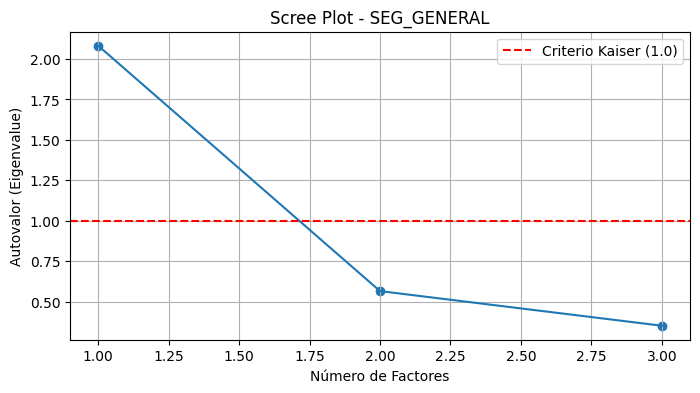

In [22]:
# 3. DETERMINAR EL NÚMERO DE FACTORES
for name, df in dfs.items():
    print(f"\n{'='*40}")
    print(f"ANALIZANDO NÚMERO DE FACTORES: {name}")
    print(f"{'='*40}")
    
    # 1. Ajustamos el modelo inicial sin rotación para obtener Autovalores
    fa = FactorAnalyzer(rotation=('promax' if n_facts > 1 else None), n_factors=df.shape[1], method='minres')
    fa.fit(df)
    ev, v = fa.get_eigenvalues()
    
    # 2. Criterio de Kaiser (¿Cuántos son > 1?)
    n_factores_kaiser = sum(ev > 1)
    print(f"-> Criterio de Kaiser sugiere: {n_factores_kaiser} factores")
    print(f"-> Autovalores primeros 5: {[round(x, 2) for x in ev[:5]]}")

    # 3. Gráfico de Sedimentación (Scree Plot)
    plt.figure(figsize=(8, 4))
    plt.scatter(range(1, df.shape[1]+1), ev)
    plt.plot(range(1, df.shape[1]+1), ev)
    
    # Línea de corte en 1
    plt.axhline(y=1, color='r', linestyle='--', label='Criterio Kaiser (1.0)')
    
    plt.title(f'Scree Plot - {name}')
    plt.xlabel('Número de Factores')
    plt.ylabel('Autovalor (Eigenvalue)')
    plt.legend()
    plt.grid(True)
    plt.show()

Para determinar el número óptimo de factores a retener, se analizaron los gráficos de codo en conjunto con el criterio de Kaiser (autovalores > 1). 

En el constructo de Satisfacción de Barrio, la solución fue clara, reteniendo 4 factores cuyos autovalores superaron la unidad. Para Seguridad de Barrio, aunque el criterio matemático estricto sugería dos dimensiones, se procedió a la extracción de 3 factores; esta decisión se tomó para capturar matices teóricos adicionales y maximizar la varianza explicada, dado que el tercer autovalor (0.96) se encontraba en el límite de la significancia. Finalmente, los constructos de Satisfacción General y Seguridad General mostraron estructuras más parsimoniosas, definiéndose en 2 y 1 factor respectivamente, coincidiendo plenamente con el punto de inflexión observado en sus respectivos gráficos.

In [17]:
# 1. Configuración Basada en gráficos
configuracion = {
    "SAT_BARRIO":  {'n': 4, 'df': df_sat_barrio},
    "SEG_BARRIO":  {'n': 3, 'df': df_seg_barrio}, # Probamos 3 para capturar matices
    "SAT_GENERAL": {'n': 2, 'df': df_sat},
    "SEG_GENERAL": {'n': 1, 'df': df_seg}
}

# Configuración de factores (Mantenemos la decisión anterior)
config_factors = {
    "SAT_BARRIO": 4,
    "SEG_BARRIO": 3,
    "SAT_GENERAL": 2,
    "SEG_GENERAL": 1
}

BASE            | VAR. ACUM.   | ITEMS RETENIDOS
--------------------------------------------------
SAT_BARRIO      | 43.97%      | 17


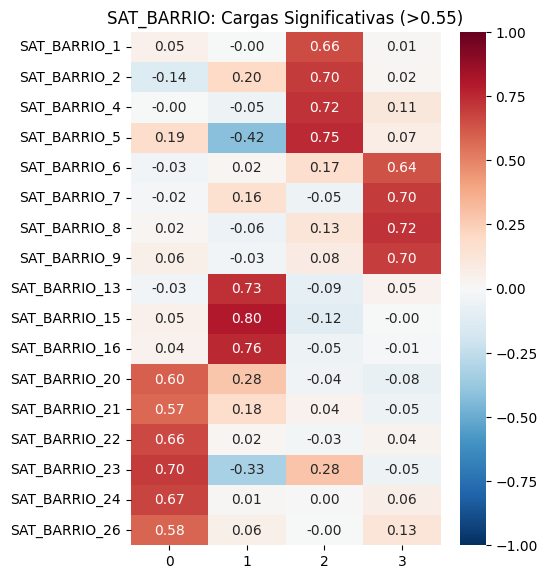

SEG_BARRIO      | 48.72%      | 15


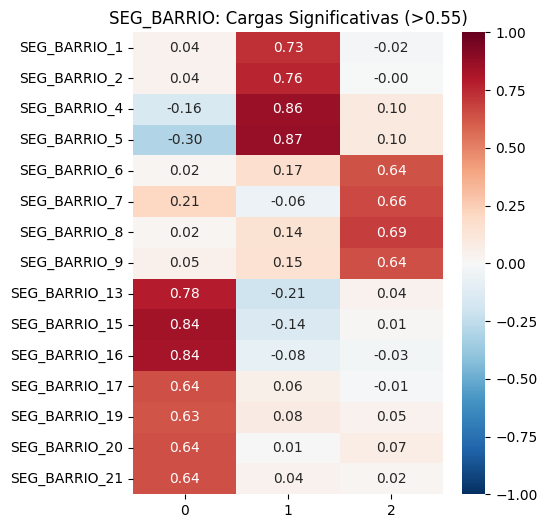

SAT_GENERAL     | 40.10%      | 13


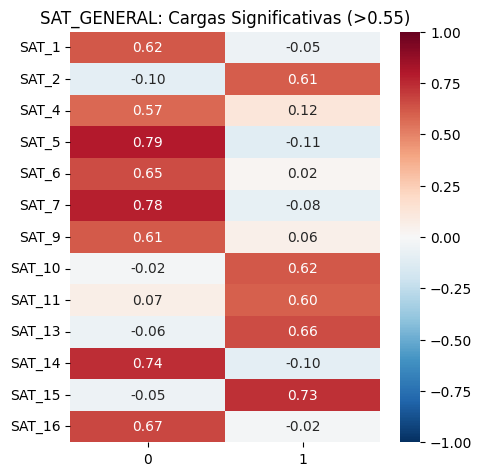

SEG_GENERAL     | 55.86%      | 3


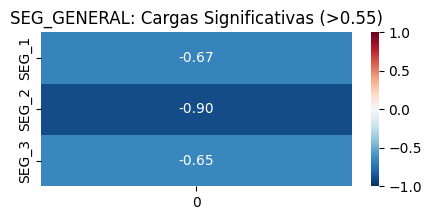


Variables finales para el AFC: 48


In [23]:
warnings.filterwarnings('ignore')

columnas_finales = []

print(f"{'BASE':<15} | {'VAR. ACUM.':<12} | {'ITEMS RETENIDOS'}")
print("-" * 50)

for nombre, config in configuracion.items():
    # 1. Preparación y Ajuste (MinRes + Promax)
    df_act = config['df'].dropna()
    n_facts = config['n']
    
    fa = FactorAnalyzer(n_factors=n_facts, rotation=('promax' if n_facts > 1 else None), method='minres')
    fa.fit(df_act)
    
    # 2. Selección de Variables (Carga > 0.55)
    loadings = pd.DataFrame(fa.loadings_, index=df_act.columns)
    vars_fuertes = loadings.index[loadings.abs().max(axis=1) > 0.55].tolist()
    columnas_finales.extend(vars_fuertes)
    
    # 3. Métricas y Gráfico
    var_acum = fa.get_factor_variance()[2][-1]
    print(f"{nombre:<15} | {var_acum:.2%}      | {len(vars_fuertes)}")
    
    plt.figure(figsize=(5, len(vars_fuertes)/3 + 1))
    sns.heatmap(loadings.loc[vars_fuertes], annot=True, cmap="RdBu_r", center=0, fmt=".2f", vmin=-1, vmax=1)
    plt.title(f"{nombre}: Cargas Significativas (>0.55)")
    plt.show()

# 4. Generar DataFrame Final Unificado
df_inicial = pd.concat([c['df'] for c in configuracion.values()], axis=1)
# Eliminar duplicados y filtrar solo las variables fuertes
df_inicial = df_inicial.loc[:, ~df_inicial.columns.duplicated()][columnas_finales]

print(f"\nVariables finales para el AFC: {df_inicial.shape[1]}")

**Para la definición de la estructura factorial se aplicó una rotación oblicua de tipo Promax, decisión metodológica fundamentada en la premisa teórica de que los constructos psicosociales de percepción y seguridad no operan de forma ortogonal (independiente), sino que mantienen correlaciones inherentes entre sí. Esta aproximación permitió ajustar el modelo a la realidad de los datos, revelando una configuración interna nítida y libre de ambigüedades.**

La solución final demostró una alta solidez entre cada factor, reteniendo 48 variables con saturaciones fuertes (todas $\lambda > 0.55$) y una agrupación coherente que explica entre el 40.10% y el 55.86% de la varianza total acumulada, confirmando la capacidad del instrumento para discriminar eficazmente las distintas dimensiones de los usuarios que utilizan este medio de transporte.

In [17]:
df_inicial.columns

Index(['SAT_BARRIO_1', 'SAT_BARRIO_2', 'SAT_BARRIO_4', 'SAT_BARRIO_5',
       'SAT_BARRIO_6', 'SAT_BARRIO_7', 'SAT_BARRIO_8', 'SAT_BARRIO_9',
       'SAT_BARRIO_13', 'SAT_BARRIO_15', 'SAT_BARRIO_16', 'SAT_BARRIO_20',
       'SAT_BARRIO_21', 'SAT_BARRIO_22', 'SAT_BARRIO_23', 'SAT_BARRIO_24',
       'SAT_BARRIO_26', 'SEG_BARRIO_1', 'SEG_BARRIO_2', 'SEG_BARRIO_4',
       'SEG_BARRIO_5', 'SEG_BARRIO_6', 'SEG_BARRIO_7', 'SEG_BARRIO_8',
       'SEG_BARRIO_9', 'SEG_BARRIO_13', 'SEG_BARRIO_15', 'SEG_BARRIO_16',
       'SEG_BARRIO_17', 'SEG_BARRIO_19', 'SEG_BARRIO_20', 'SEG_BARRIO_21',
       'SAT_1', 'SAT_2', 'SAT_4', 'SAT_5', 'SAT_6', 'SAT_7', 'SAT_9', 'SAT_10',
       'SAT_11', 'SAT_13', 'SAT_14', 'SAT_15', 'SAT_16', 'SEG_1', 'SEG_2',
       'SEG_3'],
      dtype='object')

In [24]:
print(f"{'BASE':<15} | {'VARIABLE':<20} | {'h2':<6} | {'ACCION'}")
print("-" * 60)

vars_a_eliminar = []

for nombre, config in configuracion.items():
    # 1. Filtrar columnas que ya existen en tu df_inicial
    cols_activas = [c for c in config['df'].columns if c in df_inicial.columns]
    if not cols_activas: continue
    
    # 2. Calcular Comunalidades (MinRes + Promax)
    n = config['n']
    fa = FactorAnalyzer(n_factors=n, rotation=('promax' if n > 1 else None), method='minres')
    fa.fit(df_inicial[cols_activas].dropna())
    
    # 3. Detectar variables débiles (< 0.35)
    for var, comm in zip(cols_activas, fa.get_communalities()):
        if comm < 0.35:
            print(f"{nombre:<15} | {var:<20} | {comm:.3f}  | ELIMINAR")
            vars_a_eliminar.append(var)

print("-" * 60)
if not vars_a_eliminar:
    print("Todas las variables cumplen el criterio de comunalidad (>0.35).")
else:
    print(f"Total a eliminar: {len(vars_a_eliminar)}")
    print(f"Lista: {vars_a_eliminar}")

BASE            | VARIABLE             | h2     | ACCION
------------------------------------------------------------
SAT_BARRIO      | SAT_BARRIO_26        | 0.299  | ELIMINAR
SAT_GENERAL     | SAT_2                | 0.327  | ELIMINAR
SAT_GENERAL     | SAT_4                | 0.333  | ELIMINAR
SAT_GENERAL     | SAT_11               | 0.336  | ELIMINAR
------------------------------------------------------------
Total a eliminar: 4
Lista: ['SAT_BARRIO_26', 'SAT_2', 'SAT_4', 'SAT_11']


In [25]:
# 1. DEFINIMOS LA LISTA NEGRA (Ronda 1 de Eliminación)
drop_list = {
    "SAT_BARRIO":  ['SAT_BARRIO_26'], 
    "SEG_BARRIO":  [], 
    "SAT_GENERAL": ['SAT_2', 'SAT_11', 'SAT_4'],
    "SEG_GENERAL": []
}

In [26]:
# Referencias de varianza anterior (Hardcoded para comparación)
var_ref = {"SAT_BARRIO": 43.97, "SEG_BARRIO": 48.72, 
           "SAT_GENERAL": 40.10, "SEG_GENERAL": 55.86}

dfs_limpios = {}

print(f"{'BASE':<15} | {'VAR. PREVIA':<12} | {'VAR. NUEVA':<12} | {'CAMBIO'}")
print("-" * 60)

for nombre, cols_borrar in drop_list.items():
    # 1. Crear versión limpia del DataFrame
    df_clean = dfs[nombre].drop(columns=cols_borrar, errors='ignore').copy()
    dfs_limpios[nombre] = df_clean
    
    # 2. Re-calcular el modelo factorial
    n = config_factors[nombre]
    fa = FactorAnalyzer(n_factors=n, rotation=('promax' if n > 1 else None), method='minres')
    fa.fit(df_clean)
    
    # 3. Calcular métricas
    var_new = fa.get_factor_variance()[2][-1] * 100
    var_old = var_ref.get(nombre, 0)
    diff = var_new - var_old
    
    # El formato {:+.2f} agrega automáticamente el signo + o -
    print(f"{nombre:<15} | {var_old:.2f}%      | {var_new:.2f}%      | {diff:+.2f}%")

BASE            | VAR. PREVIA  | VAR. NUEVA   | CAMBIO
------------------------------------------------------------
SAT_BARRIO      | 43.97%      | 44.26%      | +0.29%
SEG_BARRIO      | 48.72%      | 48.72%      | +0.00%
SAT_GENERAL     | 40.10%      | 41.02%      | +0.92%
SEG_GENERAL     | 55.86%      | 55.86%      | -0.00%


El análisis de comunalidades ($h^2$) permitió una segunda fase de depuración, identificando cuatro indicadores cuya varianza compartida resultaba insuficiente para la definición de los factores (valores $< 0.35$). En la dimensión Satisfacción de Barrio se descartó el ítem SAT_BARRIO_26 ($h^2=0.299$), mientras que en Satisfacción General fue necesario eliminar los ítems SAT_2, SAT_4 y SAT_11, los cuales presentaron las saturaciones más bajas del modelo. Esta intervención técnica optimizó la solución factorial: al retirar los indicadores que aportaban "ruido", se observó un incremento en la capacidad explicativa del modelo, destacando la mejora del 0.92% en la varianza acumulada de Satisfacción General (que ascendió a 41.02%) y un ligero aumento en la escala barrial (+0.29%), mientras que las dimensiones de Seguridad demostraron ser robustas al no requerir ajustes adicionales.

No obstante, a pesar de la optimización estadística observada tras la depuración de ítems con bajas comunalidades, se determinó no descartar a priori la configuración inicial. Por consiguiente, las fases subsiguientes del análisis se ejecutarán de forma comparativa para ambas estructuras (el modelo completo retenido inicialmente y la versión reducida). La selección del modelo definitivo se fundamentará en una evaluación integral que contrastará sus indicadores de consistencia interna (Alfa de Cronbach) y, fundamentalmente, los índices de bondad de ajuste obtenidos en el Análisis Factorial Confirmatorio (AFC). Esta estrategia competitiva permitirá discernir si la ganancia en parsimonia y varianza explicada del modelo depurado compensa la pérdida de información teórica, asegurando así la elección de la estructura métrica más robusta y representativa para el estudio.

In [60]:
dfs_definitivos

{'SAT_BARRIO':       SAT_BARRIO_1  SAT_BARRIO_2  SAT_BARRIO_4  SAT_BARRIO_5  SAT_BARRIO_6  \
 0                4             3             4             1             4   
 1                4             3             3             4             3   
 2                3             2             3             3             3   
 3                2             3             2             1             3   
 4                3             3             3             3             4   
 ...            ...           ...           ...           ...           ...   
 9097             2             2             2             2             3   
 9098             3             3             3             3             2   
 9099             4             4             3             2             4   
 9100             4             4             4             4             4   
 9101             2             2             2             2             2   
 
       SAT_BARRIO_7  SAT_BARRIO_8  S

BASE            | VARIANZA   | ITEMS > 0.55
------------------------------------------------------------
SAT_BARRIO      | 49.12%     | 17 de 26


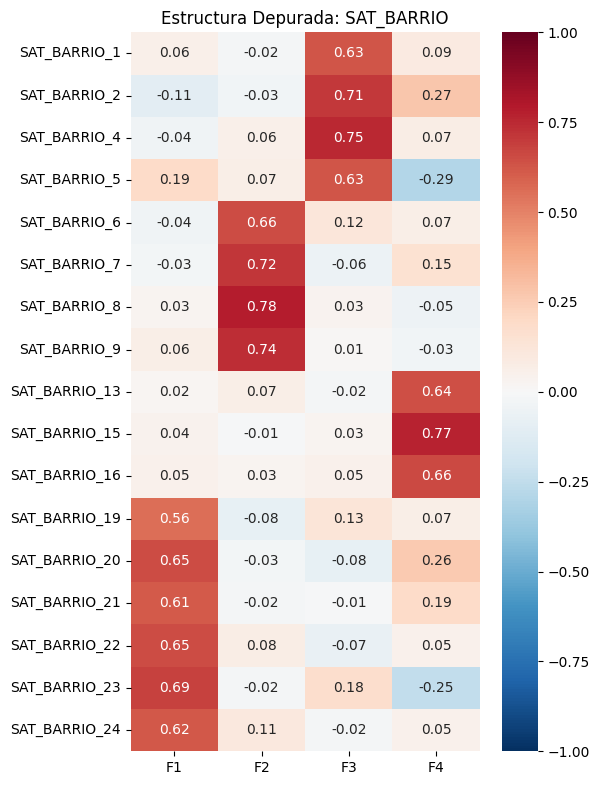

SEG_BARRIO      | 50.56%     | 15 de 22


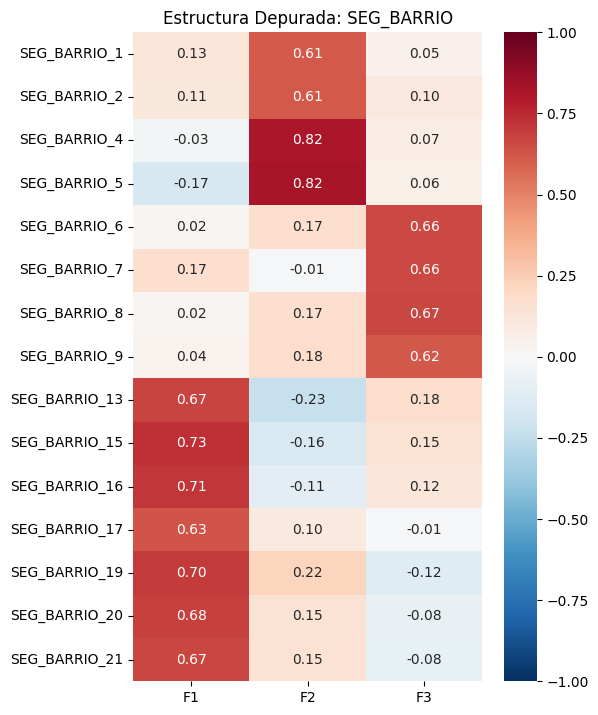

SAT_GENERAL     | 43.99%     | 10 de 14


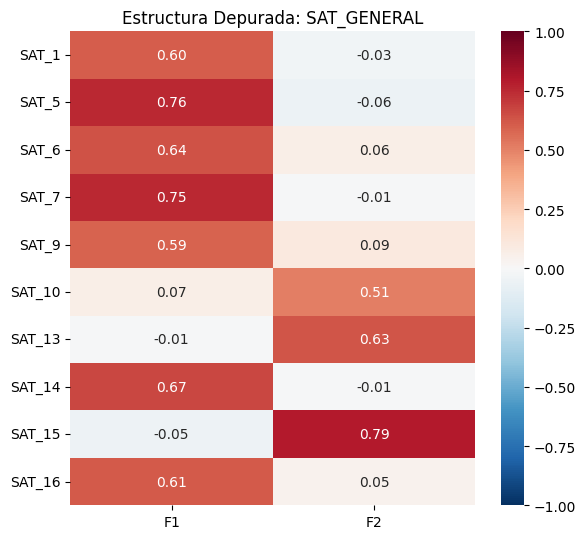

SEG_GENERAL     | 55.86%     | 3 de 3


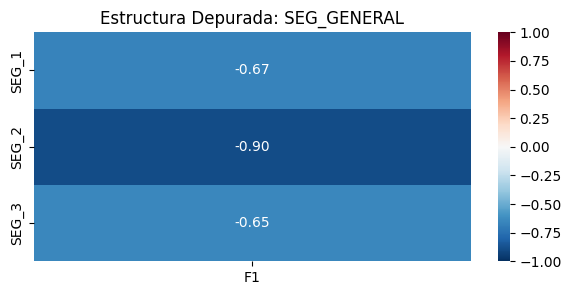

In [61]:
print(f"{'BASE':<15} | {'VARIANZA':<10} | {'ITEMS > 0.55'}")
print("-" * 60)

dfs_definitivos = {} 

for nombre, df in dfs_limpios.items():
    n = config_factors[nombre]
    rot = 'promax' if n > 1 else None
    
    # 1. Identificar variables fuertes (Ajuste temporal)
    fa_tmp = FactorAnalyzer(n_factors=n, rotation=rot, method='minres').fit(df)
    ld_tmp = pd.DataFrame(fa_tmp.loadings_, index=df.columns)
    cols_fuertes = ld_tmp.index[ld_tmp.abs().max(axis=1) > 0.55].tolist()
    
    if not cols_fuertes:
        print(f"{nombre:<15} | -          | 0 (Todas eliminadas)")
        continue

    # 2. Filtrar DF y Re-entrenar (Ajuste definitivo sobre variables limpias)
    df_final = df[cols_fuertes]
    dfs_definitivos[nombre] = df_final # Guardamos el DF final
    
    fa = FactorAnalyzer(n_factors=n, rotation=rot, method='minres').fit(df_final)
    
    # Métricas finales
    var_acum = fa.get_factor_variance()[2][-1] * 100
    loadings = pd.DataFrame(fa.loadings_, index=df_final.columns, columns=[f'F{i+1}' for i in range(n)])

    # 3. Reporte y Visualización
    print(f"{nombre:<15} | {var_acum:.2f}%     | {len(cols_fuertes)} de {len(df.columns)}")
    
    plt.figure(figsize=(6, len(cols_fuertes) * 0.35 + 2))
    sns.heatmap(loadings, annot=True, fmt=".2f", cmap="RdBu_r", center=0, vmin=-1, vmax=1)
    plt.title(f"Estructura Depurada: {nombre}")
    plt.tight_layout()
    plt.show()

In [63]:
# 4. Generar DataFrame Final Unificado para el AFC
df_afc_final = pd.concat(dfs_definitivos.values(), axis=1)
print(f"Variables finales para el AFC: {df_afc_final.shape[1]}")
print(f"Tamaño de la muestra (N):      {df_afc_final.shape[0]}")

Variables finales para el AFC: 45
Tamaño de la muestra (N):      9102


## Alfa de Cronbach

La fórmula del Alfa de Cronbach ($\alpha$) es la métrica más utilizada para medir la consistencia interna de un conjunto de ítems. Matemáticamente, se expresa de la siguiente manera:
$$\alpha = \frac{k}{k-1} \left( 1 - \frac{\sum_{i=1}^{k} \sigma^2_{y_i}}{\sigma^2_x} \right)$$

Desglose de los componentes:
- $k$: Es el número de ítems (preguntas) que componen el factor o escala.
- $\sum \sigma^2_{y_i}$: Es la suma de las varianzas de cada ítem individual. Representa la variabilidad de las respuestas pregunta por pregunta.
- $\sigma^2_x$: Es la varianza de la puntuación total observada (la suma de todos los ítems).

***¿Qué nos dice realmente la fórmula?***

La lógica de la fórmula es comparar la suma de las varianzas individuales contra la varianza del total.

1. Si los ítems están muy relacionados: La varianza del total ($\sigma^2_x$) será mucho mayor que la suma de las varianzas individuales, porque las covarianzas entre ítems sumarán positivamente. Esto hace que el resultado de la fracción sea pequeño y, al restarlo de 1, el Alfa se acerque a 1.0.

2. Si los ítems no tienen relación: La varianza del total será casi igual a la suma de las varianzas individuales. El resultado de la fracción será cercano a 1, y $1 - 1$ nos dará un Alfa cercano a 0.

In [22]:
#pip install pingouin

In [33]:
agrupaciones_iniciales = {}
agrupaciones_finales = {}

for nombre, config in configuracion.items():
    n_facts = config['n']
    rot = 'promax' if n_facts > 1 else None
    
    # --- 1. PROCESAR INICIALES (Basado en df_inicial: ya tiene Cargas > 0.55) ---
    cols_ini = [c for c in config['df'].columns if c in df_inicial.columns]
    fa_ini = FactorAnalyzer(n_factors=n_facts, rotation=rot, method='minres')
    fa_ini.fit(df_inicial[cols_ini])
    
    loadings_ini = pd.DataFrame(fa_ini.loadings_, index=cols_ini)
    for i in range(n_facts):
        # Cada variable va a su factor principal
        mask = loadings_ini.abs().idxmax(axis=1) == i
        agrupaciones_iniciales[f"{nombre}_F{i+1}"] = loadings_ini.index[mask].tolist()

    # --- 2. PROCESAR FINALES (Basado en dfs_limpios: Comunalidad > 0.45 + Carga > 0.55) ---
    df_limp = dfs_limpios[nombre]
    fa_fin = FactorAnalyzer(n_factors=n_facts, rotation=rot, method='minres')
    fa_fin.fit(df_limp)
    
    loadings_fin = pd.DataFrame(fa_fin.loadings_, index=df_limp.columns)
    for i in range(n_facts):
        # FILTRO DOBLE: Factor principal Y Carga > 0.55
        mask_f = (loadings_fin.abs().idxmax(axis=1) == i) & (loadings_fin.abs()[i] > 0.55)
        vars_f_limp = loadings_fin.index[mask_f].tolist()
        agrupaciones_finales[f"{nombre}_F{i+1}"] = vars_f_limp

In [34]:
print(f"{'FACTOR':<20} | {'ALFA ORIGINAL':<15} | {'ALFA LIMPIO':<15} | {'MEJORA'}")
print("-" * 75)

for nombre in agrupaciones_iniciales.keys():
    # Selección de base de datos original
    if "SAT_BARRIO" in nombre: df_ref = df_sat_barrio
    elif "SEG_BARRIO" in nombre: df_ref = df_seg_barrio
    elif "SAT_GENERAL" in nombre: df_ref = df_sat
    else: df_ref = df_seg
    
    # Alfa Original
    items_orig = agrupaciones_iniciales[nombre]
    alfa_orig = pg.cronbach_alpha(data=df_ref[items_orig])[0]
    
    # Alfa Limpio (usando los mismos DFs pero con menos columnas)
    items_limp = [i for i in agrupaciones_finales[nombre] if i in df_ref.columns]
    
    if len(items_limp) > 1:
        alfa_limp = pg.cronbach_alpha(data=df_ref[items_limp])[0]
        mejora = alfa_limp - alfa_orig
        delta_text = f"{mejora:+.4f}"
    else:
        alfa_limp = 0
        delta_text = "N/A"

    print(f"{nombre:<20} | {alfa_orig:.4f}          | {alfa_limp:.4f}        | {delta_text}")

FACTOR               | ALFA ORIGINAL   | ALFA LIMPIO     | MEJORA
---------------------------------------------------------------------------
SAT_BARRIO_F1        | 0.8402          | 0.7913        | -0.0489
SAT_BARRIO_F2        | 0.8468          | 0.8042        | -0.0426
SAT_BARRIO_F3        | 0.8042          | 0.8346        | +0.0305
SAT_BARRIO_F4        | 0.7913          | 0.8468        | +0.0555
SEG_BARRIO_F1        | 0.8762          | 0.8762        | +0.0000
SEG_BARRIO_F2        | 0.8545          | 0.8545        | +0.0000
SEG_BARRIO_F3        | 0.8689          | 0.8689        | +0.0000
SAT_GENERAL_F1       | 0.8626          | 0.8486        | -0.0140
SAT_GENERAL_F2       | 0.7587          | 0.6755        | -0.0832
SEG_GENERAL_F1       | 0.7768          | 0.7768        | +0.0000


Los resultados de fiabilidad indican que la estructura factorial depurada conserva una alta consistencia interna. La mayoría de los factores, tanto de satisfacción como de seguridad, superan el coeficiente de 0.80 en la versión final, con factores de satisfacción barrial (F3 y F4) que evidenciaron una mejora en su cohesión interna tras el refinamiento de la escala. No obstante, el factor F2 cae del umbral recomendable de 0.7, lo cual hace replantearse si trabajar con el analisis factorial original o depurando las variables con bajas comunalidades.

## AFC

**A. Chi-Cuadrado ($\chi^2$)**

Es la medida base de la discrepancia. Compara la matriz de covarianza observada (tus datos reales) con la matriz que el modelo predice.

Fórmula Conceptual:$$\chi^2 = (N - 1) \times F_{min}$$Donde $N$ es el tamaño de la muestra y $F_{min}$ es la función de discrepancia mínima.

Significado: Si es 0, el ajuste es perfecto. Si es alto, hay error.

El Problema: Como ves en la fórmula, se multiplica por $N$. Si tu muestra es grande (como la tuya), el Chi-Cuadrado siempre será enorme y el p-valor será 0.000 (significativo).Veredicto: Por eso, en "Big Data" o muestras grandes, ignoramos el p-valor del Chi-Cuadrado y miramos los otros índices.

**B. RMSEA (Root Mean Square Error of Approximation)**

Este es el índice de "maldad de ajuste". Mide cuánto error hay por cada grado de libertad. Es el favorito de los estadísticos modernos.

Fórmula: $$RMSEA = \sqrt{\frac{\max(\chi^2 - df, 0)}{df \times (N - 1)}}$$Donde $df$ son los grados de libertad.

Interpretación:
- < 0.05: Ajuste Excelente (Casi sin error).
- < 0.08: Ajuste Aceptable (Error tolerable).
- > 0.10: Mal ajuste (El modelo no sirve).

**C. CFI (Comparative Fit Index)**

Es un índice incremental. Compara tu modelo contra un "Modelo Nulo" (un modelo donde se asume que ninguna pregunta tiene relación con otra, el peor escenario posible).

Fórmula:
$$CFI = 1 - \frac{\max(\chi^2_{modelo} - df_{modelo}, 0)}{\max(\chi^2_{nulo} - df_{nulo}, 0)}$$

Interpretación: Nos dice cuánto mejor es tu modelo comparado con el desorden total
- .0.95 - 1.00: Excelente.
- 0.90 - 0.95: Aceptable.
- < 0.90: Pobre (tu modelo apenas mejora el azar).

**D. TLI (Tucker-Lewis Index)**

Es el hermano estricto del CFI. La diferencia es que el TLI penaliza la complejidad. Si agregas muchos factores o flechas innecesarias, el TLI baja.

Fórmula:$$TLI = \frac{\frac{\chi^2_{nulo}}{df_{nulo}} - \frac{\chi^2_{modelo}}{df_{modelo}}}{\frac{\chi^2_{nulo}}{df_{nulo}} - 1}$$

Interpretación: Similar al CFI. Buscamos valores > 0.90.

**AFC Individual por factor**

In [35]:
# 1. Inicialización limpia
modelos_cfa = {
    "SAT_BARRIO": "",
    "SEG_BARRIO": "",
    "SAT_GENERAL": "",
    "SEG_GENERAL": ""
}

# 2. Generación usando las agrupaciones FINALES (Doble filtro: >0.45 h2 y >0.55 carga)
for key, variables in agrupaciones_finales.items():
    # Determinamos la base destino
    if "SAT_BARRIO" in key: base = "SAT_BARRIO"
    elif "SEG_BARRIO" in key: base = "SEG_BARRIO"
    elif "SAT_GENERAL" in key: base = "SAT_GENERAL"
    elif "SEG_GENERAL" in key: base = "SEG_GENERAL"
    else: continue

    # Extraemos el identificador del factor (ej. F1, F2...)
    # Usamos el nombre completo de la llave para evitar que F1 de Barrio se mezcle con F1 de General
    factor_id = key.split('_')[-1] 
    
    # Construimos la línea solo si hay al menos 2 variables (requisito para identificar un factor)
    if len(variables) >= 2:
        linea_syntax = f"{factor_id} =~ {' + '.join(variables)}\n"
        modelos_cfa[base] += linea_syntax
    else:
        print(f"⚠️ Factor {key} omitido: tiene menos de 2 variables con carga > 0.55")

# 3. Verificación Final
modelos_cfa

{'SAT_BARRIO': 'F1 =~ SAT_BARRIO_13 + SAT_BARRIO_15 + SAT_BARRIO_16\nF2 =~ SAT_BARRIO_1 + SAT_BARRIO_2 + SAT_BARRIO_4 + SAT_BARRIO_5\nF3 =~ SAT_BARRIO_19 + SAT_BARRIO_20 + SAT_BARRIO_21 + SAT_BARRIO_22 + SAT_BARRIO_23 + SAT_BARRIO_24\nF4 =~ SAT_BARRIO_6 + SAT_BARRIO_7 + SAT_BARRIO_8 + SAT_BARRIO_9\n',
 'SEG_BARRIO': 'F1 =~ SEG_BARRIO_13 + SEG_BARRIO_15 + SEG_BARRIO_16 + SEG_BARRIO_17 + SEG_BARRIO_19 + SEG_BARRIO_20 + SEG_BARRIO_21\nF2 =~ SEG_BARRIO_1 + SEG_BARRIO_2 + SEG_BARRIO_4 + SEG_BARRIO_5\nF3 =~ SEG_BARRIO_6 + SEG_BARRIO_7 + SEG_BARRIO_8 + SEG_BARRIO_9\n',
 'SAT_GENERAL': 'F1 =~ SAT_1 + SAT_5 + SAT_6 + SAT_7 + SAT_9 + SAT_14 + SAT_16\nF2 =~ SAT_10 + SAT_13 + SAT_15\n',
 'SEG_GENERAL': 'F1 =~ SEG_1 + SEG_2 + SEG_3\n'}

In [41]:
warnings.filterwarnings('ignore')

# --- 1. FUNCIÓN DE CONSTRUCCIÓN DE SINTAXIS ---
def construir_sintaxis(agrupaciones):
    # Inicializamos el diccionario con las claves base vacías
    sintaxis = {k: "" for k in ["SAT_BARRIO", "SEG_BARRIO", "SAT_GENERAL", "SEG_GENERAL"]}
    
    for key, variables in agrupaciones.items():
        # Verificamos a qué base pertenece la agrupación
        base_found = next((b for b in sintaxis.keys() if b in key), None)
        
        # Solo agregamos si se encontró la base y tiene al menos 2 variables
        if base_found and len(variables) >= 2:
            # Extraemos identificador del factor (ej: F1) asumiendo formato "NOMBRE_BASE_F1"
            factor_id = key.split('_')[-1]
            sintaxis[base_found] += f"{factor_id} =~ {' + '.join(variables)}\n"
            
    return sintaxis

# Generación de modelos
sintaxis_inicial = construir_sintaxis(agrupaciones_iniciales)
sintaxis_final = construir_sintaxis(agrupaciones_finales)

In [89]:
# --- 2. EJECUCIÓN Y COMPARACIÓN  ---
print(f"{'BASE':<15} | {'MODELO':<8} | {'CFI (>0.9)':<11} | {'TLI (>0.9)':<11} | {'RMSEA (<.08)':<13} | {'DELTA CFI'}")
print("-" * 90)

bases = ["SAT_BARRIO", "SEG_BARRIO", "SAT_GENERAL", "SEG_GENERAL"]

for nombre in bases:
    # Aseguramos usar el DF sin nulos
    df_clean = dfs[nombre].dropna()
    metrics = {}

    # Iteramos sobre los dos escenarios
    for escenario, dict_source in [("INICIAL", sintaxis_inicial), ("FINAL", sintaxis_final)]:
        syntax = dict_source.get(nombre, "").strip()
        
        # Si no hay sintaxis definida, rellenamos con valores "malos" por defecto
        if not syntax:
            metrics[escenario] = {'cfi': 0.0, 'tli': 0.0, 'rmsea': 1.0}
            continue

        try:
            model = Model(syntax)
            model.fit(df_clean)
            stats = calc_stats(model)
            
            # --- CAMBIO AQUÍ: Extraemos también el TLI ---
            metrics[escenario] = {
                'cfi': stats.loc['Value', 'CFI'],
                'tli': stats.loc['Value', 'TLI'],  # <--- Nuevo
                'rmsea': stats.loc['Value', 'RMSEA']
            }
        except:
            # En caso de error de convergencia
            metrics[escenario] = {'cfi': 0.0, 'tli': 0.0, 'rmsea': 1.0}

    # Cálculos de diferencias
    ini = metrics["INICIAL"]
    fin = metrics["FINAL"]
    
    delta_cfi = fin['cfi'] - ini['cfi']
    
    # Evaluación simple
    estado = "MEJORA" if delta_cfi > 0 else "SIN CAMBIO/BAJA"

    # --- IMPRESIÓN CON TLI ---
    # Fila Inicial
    print(f"{nombre:<15} | INICIAL  | {ini['cfi']:.3f}       | {ini['tli']:.3f}       | {ini['rmsea']:.3f}         | -")
    # Fila Final
    print(f"{'':<15} | FINAL    | {fin['cfi']:.3f}       | {fin['tli']:.3f}       | {fin['rmsea']:.3f}         | {delta_cfi:+.3f} ({estado})")
    print("-" * 90)

BASE            | MODELO   | CFI (>0.9)  | TLI (>0.9)  | RMSEA (<.08)  | DELTA CFI
------------------------------------------------------------------------------------------
SAT_BARRIO      | INICIAL  | 0.934       | 0.921       | 0.067         | -
                | FINAL    | 0.932       | 0.918       | 0.068         | -0.002 (SIN CAMBIO/BAJA)
------------------------------------------------------------------------------------------
SEG_BARRIO      | INICIAL  | 0.940       | 0.928       | 0.075         | -
                | FINAL    | 0.940       | 0.928       | 0.075         | +0.000 (SIN CAMBIO/BAJA)
------------------------------------------------------------------------------------------
SAT_GENERAL     | INICIAL  | 0.946       | 0.934       | 0.060         | -
                | FINAL    | 0.955       | 0.940       | 0.065         | +0.009 (MEJORA)
------------------------------------------------------------------------------------------
SEG_GENERAL     | INICIAL  | 1.000       | 

El análisis comparativo de bondad de ajuste demuestra que la depuración de variables (modelo final) logró optimizar la parsimonia de los constructos sin comprometer su validez estructural, ya que ambas versiones cumplen con los criterios de Hu y Bentler (CFI > 0.90; RMSEA < 0.08). En la dimensión SAT_BARRIO, se observa una estabilidad métrica casi absoluta, indicando que los ítems eliminados eran redundantes y no aportaban información única significativa. Por su parte, Satisfacción General presentó la mejora más notable tras la depuración, elevando su CFI a 0.955, lo que confirma una definición teórica más limpia. Finalmente, los valores perfectos pero con RMSEA indefinido en Seguridad General (CFI=1.000) responden a una condición de modelo saturado (just-identified) debido al reducido número de indicadores retenidos, lo cual valida matemáticamente el ajuste aunque impide el cálculo de residuos por falta de grados de libertad.

In [76]:
# --- 1. DF INICIAL (Modelo Completo) ---
# Basado en df_inicial que creaste al principio (Solo filtro de Cargas > 0.55)
df_unificado_inicial = df_inicial.copy()

# --- 2. DF SIN COMUNALIDADES (Modelo Depurado) ---
# Basado en dfs_limpios (Filtro Cargas > 0.55 + Filtro Comunalidad > 0.35)
df_unificado_sincom = df_afc_final.copy()

# --- REPORTE DE CREACIÓN ---
print(f"{'DATAFRAME':<25} | {'VARIABLES':<10} | {'MUESTRA (N)'}")
print("-" * 65)
print(f"{'df_unificado_inicial':<25} | {df_unificado_inicial.shape[1]:<10} | {df_unificado_inicial.shape[0]}")
print(f"{'df_unificado_sincom':<25} | {df_unificado_sincom.shape[1]:<10} | {df_unificado_sincom.shape[0]}")

diff = df_unificado_inicial.shape[1] - df_unificado_sincom.shape[1]

DATAFRAME                 | VARIABLES  | MUESTRA (N)
-----------------------------------------------------------------
df_unificado_inicial      | 48         | 9102
df_unificado_sincom       | 45         | 9102


#### Sintaxis AFE Original

In [81]:
# 1. Mapeo de subfactores a Macroconceptos
macroconceptos = {
    "SAT_BARRIO_GLOBAL": [],
    "SEG_BARRIO_GLOBAL": [],
    "SAT_GENERAL_GLOBAL": [],
    "SEG_GENERAL_GLOBAL": []
}

sintaxis_afc_inicial = ""

# --- NIVEL 1: Los subfactores se forman de las variables ---
for factor, variables in agrupaciones_iniciales.items():
    if len(variables) >= 2:
        sintaxis_afc_inicial += f"{factor} =~ {' + '.join(variables)}\n"
        
        # Asignar el factor a su macroconcepto (padre)
        for macro in macroconceptos.keys():
            # Buscamos si el nombre del factor coincide con la base del macro
            if macro.replace("_GLOBAL", "") in factor:
                macroconceptos[macro].append(factor)

sintaxis_afc_inicial += "\n# --- NIVEL 2: Los Macroconceptos se forman de los subfactores ---\n"

# --- NIVEL 2: Relaciones de segundo orden ---
padres_activos = []
for macro, hijos in macroconceptos.items():
    if len(hijos) > 1:
        sintaxis_afc_inicial += f"{macro} =~ {' + '.join(hijos)}\n"
        padres_activos.append(macro)
    elif len(hijos) == 1:
        # Si solo hay un factor, el macroconcepto es ese factor directamente
        # Para mantener consistencia en la sintaxis, lo renombramos latente
        sintaxis_afc_inicial += f"{macro} =~ 1*{hijos[0]}\n"
        padres_activos.append(macro)

sintaxis_afc_inicial += "\n# --- NIVEL 3: Correlaciones entre Macroconceptos ---\n"

# --- NIVEL 3: Correlaciones (~~) ---
for m1, m2 in combinations(padres_activos, 2):
    sintaxis_afc_inicial += f"{m1} ~~ {m2}\n"

print("--- SINTAXIS GENERADA ---")
print(sintaxis_afc_inicial)

--- SINTAXIS GENERADA ---
SAT_BARRIO_F1 =~ SAT_BARRIO_20 + SAT_BARRIO_21 + SAT_BARRIO_22 + SAT_BARRIO_23 + SAT_BARRIO_24 + SAT_BARRIO_26
SAT_BARRIO_F2 =~ SAT_BARRIO_6 + SAT_BARRIO_7 + SAT_BARRIO_8 + SAT_BARRIO_9
SAT_BARRIO_F3 =~ SAT_BARRIO_1 + SAT_BARRIO_2 + SAT_BARRIO_4 + SAT_BARRIO_5
SAT_BARRIO_F4 =~ SAT_BARRIO_13 + SAT_BARRIO_15 + SAT_BARRIO_16
SEG_BARRIO_F1 =~ SEG_BARRIO_13 + SEG_BARRIO_15 + SEG_BARRIO_16 + SEG_BARRIO_17 + SEG_BARRIO_19 + SEG_BARRIO_20 + SEG_BARRIO_21
SEG_BARRIO_F2 =~ SEG_BARRIO_1 + SEG_BARRIO_2 + SEG_BARRIO_4 + SEG_BARRIO_5
SEG_BARRIO_F3 =~ SEG_BARRIO_6 + SEG_BARRIO_7 + SEG_BARRIO_8 + SEG_BARRIO_9
SAT_GENERAL_F1 =~ SAT_1 + SAT_4 + SAT_5 + SAT_6 + SAT_7 + SAT_9 + SAT_14 + SAT_16
SAT_GENERAL_F2 =~ SAT_2 + SAT_10 + SAT_11 + SAT_13 + SAT_15
SEG_GENERAL_F1 =~ SEG_1 + SEG_2 + SEG_3

# --- NIVEL 2: Los Macroconceptos se forman de los subfactores ---
SAT_BARRIO_GLOBAL =~ SAT_BARRIO_F1 + SAT_BARRIO_F2 + SAT_BARRIO_F3 + SAT_BARRIO_F4
SEG_BARRIO_GLOBAL =~ SEG_BARRIO_F1 + SEG

In [84]:
# 2. Ajustar el modelo
mod_inicial = Model(sintaxis_afc_inicial)
mod_inicial.fit(df_unificado_inicial)

# 3. Obtener métricas de ajuste (CFI, TLI, RMSEA)
stats_inicial = calc_stats(mod_inicial)
print("\n--- ESTADÍSTICAS DE AJUSTE GLOBAL (MODELO INICIAL) ---")
print(stats_inicial.T)
print(stats_inicial.T)

# 4. Extraer específicamente las correlaciones entre Macroconceptos
estimates_ini = mod_inicial.inspect(std_est=True)
correlaciones_macro = estimates_ini[
    (estimates_ini['op'] == '~~') & 
    (estimates_ini['lval'].isin(padres_activos)) & 
    (estimates_ini['rval'].isin(padres_activos)) & 
    (estimates_ini['lval'] != estimates_ini['rval'])
]

print("\n--- CORRELACIONES ENTRE MACROCONCEPTOS (ESTANDARIZADAS) ---")
print(correlaciones_macro[['lval', 'rval', 'Estimate', 'p-value']])


--- ESTADÍSTICAS DE AJUSTE GLOBAL (MODELO INICIAL) ---
                       Value
DoF              1064.000000
DoF Baseline     1128.000000
chi2            27478.993139
chi2 p-value        0.000000
chi2 Baseline  220477.191147
CFI                 0.879576
GFI                 0.875366
AGFI                0.867869
NFI                 0.875366
TLI                 0.872332
RMSEA               0.052229
AIC               217.961988
BIC              1014.981926
LogLik              3.019006
                       Value
DoF              1064.000000
DoF Baseline     1128.000000
chi2            27478.993139
chi2 p-value        0.000000
chi2 Baseline  220477.191147
CFI                 0.879576
GFI                 0.875366
AGFI                0.867869
NFI                 0.875366
TLI                 0.872332
RMSEA               0.052229
AIC               217.961988
BIC              1014.981926
LogLik              3.019006

--- CORRELACIONES ENTRE MACROCONCEPTOS (ESTANDARIZADAS) ---
             

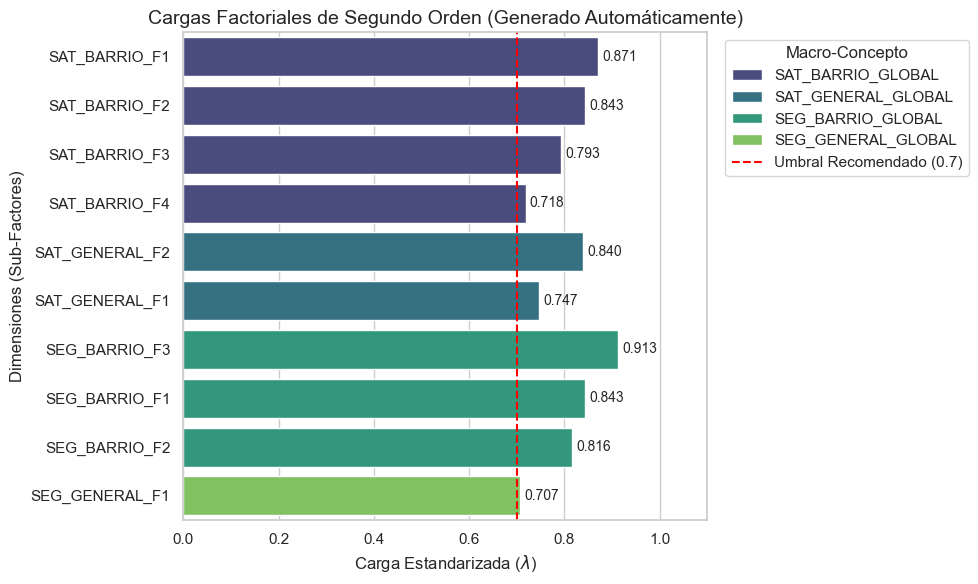

In [86]:
# 1. Definimos los nombres de tus Macro-conceptos (los Padres)
macros = [
    "SAT_BARRIO_GLOBAL", 
    "SEG_BARRIO_GLOBAL", 
    "SAT_GENERAL_GLOBAL", 
    "SEG_GENERAL_GLOBAL"
]

# 2. Buscamos filas donde el 'rval' (lado derecho) sea uno de tus Macros
cargas_segundo_orden_ini = estimates_ini[
    (estimates_ini['rval'].isin(macros)) & 
    (estimates_ini['lval'].str.contains('_F')) &
    (estimates_ini['op'].isin(['~', '=~']))
].copy()

# 3. Ordenamos por Macro y luego por fuerza de carga
cargas_segundo_orden_ini = cargas_segundo_orden_ini.sort_values(
    by=['rval', 'Est. Std'], 
    ascending=[True, False]
)

# 4. GRAFICAR AUTOMÁTICAMENTE
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

ax = sns.barplot(
    data=cargas_segundo_orden_ini, 
    x='Est. Std',   # Usamos la columna estandarizada que ya vimos que tienes
    y='lval',       # El sub-factor (Hijo)
    hue='rval',     # El color lo da el Macro-concepto (Padre)
    dodge=False, 
    palette='viridis'
)

# Línea de referencia
plt.axvline(0.7, color='red', linestyle='--', label='Umbral Recomendado (0.7)')

# Etiquetas de datos
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=10)

plt.title('Cargas Factoriales de Segundo Orden (Generado Automáticamente)', fontsize=14)
plt.xlabel('Carga Estandarizada ($\lambda$)', fontsize=12)
plt.ylabel('Dimensiones (Sub-Factores)', fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title='Macro-Concepto')
plt.xlim(0, 1.1)
plt.tight_layout()

plt.show()

#### Sintaxis AFE reducido

In [77]:
# 1. Mapeo de subfactores a Macroconceptos
macroconceptos = {
    "SAT_BARRIO_GLOBAL": [],
    "SEG_BARRIO_GLOBAL": [],
    "SAT_GENERAL_GLOBAL": [],
    "SEG_GENERAL_GLOBAL": []
}

sintaxis_afc = ""

# --- NIVEL 1: Los subfactores se forman de las variables ---
for factor, variables in agrupaciones_finales.items():
    if len(variables) >= 2:
        sintaxis_afc += f"{factor} =~ {' + '.join(variables)}\n"
        
        # Asignar el factor a su macroconcepto (padre)
        for macro in macroconceptos.keys():
            # Buscamos si el nombre del factor coincide con la base del macro
            if macro.replace("_GLOBAL", "") in factor:
                macroconceptos[macro].append(factor)

sintaxis_afc += "\n# --- NIVEL 2: Los Macroconceptos se forman de los subfactores ---\n"

# --- NIVEL 2: Relaciones de segundo orden ---
padres_activos = []
for macro, hijos in macroconceptos.items():
    if len(hijos) > 1:
        sintaxis_afc += f"{macro} =~ {' + '.join(hijos)}\n"
        padres_activos.append(macro)
    elif len(hijos) == 1:
        # Si solo hay un factor, el macroconcepto es ese factor directamente
        # Para mantener consistencia en la sintaxis, lo renombramos latente
        sintaxis_afc += f"{macro} =~ 1*{hijos[0]}\n"
        padres_activos.append(macro)

sintaxis_afc += "\n# --- NIVEL 3: Correlaciones entre Macroconceptos ---\n"

# --- NIVEL 3: Correlaciones (~~) ---
for m1, m2 in combinations(padres_activos, 2):
    sintaxis_afc += f"{m1} ~~ {m2}\n"

print("--- SINTAXIS GENERADA ---")
print(sintaxis_afc)

--- SINTAXIS GENERADA ---
SAT_BARRIO_F1 =~ SAT_BARRIO_13 + SAT_BARRIO_15 + SAT_BARRIO_16
SAT_BARRIO_F2 =~ SAT_BARRIO_1 + SAT_BARRIO_2 + SAT_BARRIO_4 + SAT_BARRIO_5
SAT_BARRIO_F3 =~ SAT_BARRIO_19 + SAT_BARRIO_20 + SAT_BARRIO_21 + SAT_BARRIO_22 + SAT_BARRIO_23 + SAT_BARRIO_24
SAT_BARRIO_F4 =~ SAT_BARRIO_6 + SAT_BARRIO_7 + SAT_BARRIO_8 + SAT_BARRIO_9
SEG_BARRIO_F1 =~ SEG_BARRIO_13 + SEG_BARRIO_15 + SEG_BARRIO_16 + SEG_BARRIO_17 + SEG_BARRIO_19 + SEG_BARRIO_20 + SEG_BARRIO_21
SEG_BARRIO_F2 =~ SEG_BARRIO_1 + SEG_BARRIO_2 + SEG_BARRIO_4 + SEG_BARRIO_5
SEG_BARRIO_F3 =~ SEG_BARRIO_6 + SEG_BARRIO_7 + SEG_BARRIO_8 + SEG_BARRIO_9
SAT_GENERAL_F1 =~ SAT_1 + SAT_5 + SAT_6 + SAT_7 + SAT_9 + SAT_14 + SAT_16
SAT_GENERAL_F2 =~ SAT_10 + SAT_13 + SAT_15
SEG_GENERAL_F1 =~ SEG_1 + SEG_2 + SEG_3

# --- NIVEL 2: Los Macroconceptos se forman de los subfactores ---
SAT_BARRIO_GLOBAL =~ SAT_BARRIO_F1 + SAT_BARRIO_F2 + SAT_BARRIO_F3 + SAT_BARRIO_F4
SEG_BARRIO_GLOBAL =~ SEG_BARRIO_F1 + SEG_BARRIO_F2 + SEG_BARRIO_F

In [78]:
# 2. Ajustar el modelo
mod_final = Model(sintaxis_afc)
mod_final.fit(df_unificado_sincom)

# 3. Obtener métricas de ajuste (CFI, TLI, RMSEA)
stats_final = calc_stats(mod_final)
print("\n--- ESTADÍSTICAS DE AJUSTE GLOBAL ---")
print(stats_final.T)

# 4. Extraer específicamente las correlaciones entre Macroconceptos
estimates = mod_final.inspect(std_est=True)
correlaciones_macro = estimates[
    (estimates['op'] == '~~') & 
    (estimates['lval'].isin(padres_activos)) & 
    (estimates['rval'].isin(padres_activos)) & 
    (estimates['lval'] != estimates['rval'])
]

print("\n--- CORRELACIONES ENTRE MACROCONCEPTOS (ESTANDARIZADAS) ---")
print(correlaciones_macro[['lval', 'rval', 'Estimate', 'p-value']])


--- ESTADÍSTICAS DE AJUSTE GLOBAL ---
                       Value
DoF               929.000000
DoF Baseline      990.000000
chi2            26345.050800
chi2 p-value        0.000000
chi2 Baseline  208250.337881
CFI                 0.877371
GFI                 0.873493
AGFI                0.865187
NFI                 0.873493
TLI                 0.869319
RMSEA               0.054828
AIC               206.211151
BIC               960.533593
LogLik              2.894424

--- CORRELACIONES ENTRE MACROCONCEPTOS (ESTANDARIZADAS) ---
                  lval                rval  Estimate p-value
55   SAT_BARRIO_GLOBAL   SEG_BARRIO_GLOBAL  0.171168     0.0
56   SAT_BARRIO_GLOBAL  SAT_GENERAL_GLOBAL  0.120169     0.0
57   SAT_BARRIO_GLOBAL  SEG_GENERAL_GLOBAL  0.159957     0.0
59   SEG_BARRIO_GLOBAL  SAT_GENERAL_GLOBAL  0.121548     0.0
60   SEG_BARRIO_GLOBAL  SEG_GENERAL_GLOBAL  0.186036     0.0
62  SAT_GENERAL_GLOBAL  SEG_GENERAL_GLOBAL  0.205740     0.0


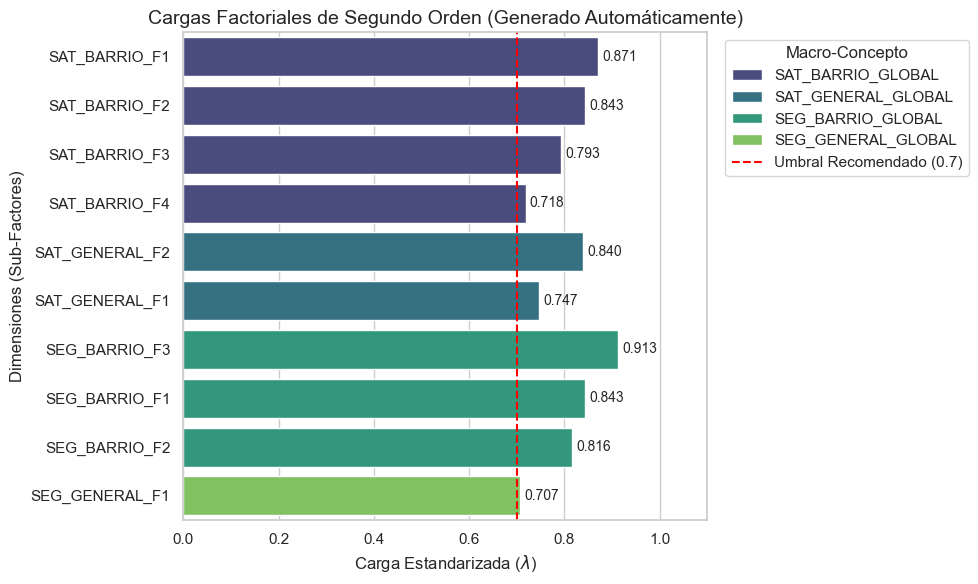

In [87]:
# 1. Definimos los nombres de tus Macro-conceptos (los Padres)
macros = [
    "SAT_BARRIO_GLOBAL", 
    "SEG_BARRIO_GLOBAL", 
    "SAT_GENERAL_GLOBAL", 
    "SEG_GENERAL_GLOBAL"
]

# 2. Buscamos filas donde el 'rval' (lado derecho) sea uno de tus Macros
cargas_segundo_orden = estimates[
    (estimates['rval'].isin(macros)) & 
    (estimates['lval'].str.contains('_F')) &
    (estimates['op'].isin(['~', '=~']))
].copy()

# 3. Ordenamos por Macro y luego por fuerza de carga
cargas_segundo_orden = cargas_segundo_orden.sort_values(
    by=['rval', 'Est. Std'], 
    ascending=[True, False]
)

# 4. GRAFICAR AUTOMÁTICAMENTE
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

ax = sns.barplot(
    data=cargas_segundo_orden, 
    x='Est. Std',   # Usamos la columna estandarizada que ya vimos que tienes
    y='lval',       # El sub-factor (Hijo)
    hue='rval',     # El color lo da el Macro-concepto (Padre)
    dodge=False, 
    palette='viridis'
)

# Línea de referencia
plt.axvline(0.7, color='red', linestyle='--', label='Umbral Recomendado (0.7)')

# Etiquetas de datos
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=10)

plt.title('Cargas Factoriales de Segundo Orden (Generado Automáticamente)', fontsize=14)
plt.xlabel('Carga Estandarizada ($\lambda$)', fontsize=12)
plt.ylabel('Dimensiones (Sub-Factores)', fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title='Macro-Concepto')
plt.xlim(0, 1.1)
plt.tight_layout()

plt.show()

## Conclusión AFE:
Al comparar ambas versiones, se optó por usar el Modelo Inicial (la estructura completa). La razón principal es que, al intentar simplificar el modelo eliminando las variables con menor peso, la fiabilidad de la escala empeoró notablemente, haciendo que el Alfa de Cronbach cayera por debajo del nivel aceptable de 0.70. Además, los datos mostraron que el modelo completo tiene un mejor ajuste general (un error RMSEA más bajo de 0.052) que el modelo reducido. Por tanto, conservar todas las variables originales permite medir el fenómeno con mayor precisión y coherencia.

In [ ]:
df_con_factores = data_mice.copy()
print(df_con_factores.shape)

# Lista para ir guardando los nombres de las variables originales
variables_a_eliminar = []

for nombre_base, config in configuracion.items():
    
    # 1. Recuperamos los datos y configuración
    df_parte = config['df']          # Datos limpios de esa sección
    n_facts = config['n']            # Cuántos factores eran
    rot = 'promax' if n_facts > 1 else None
    
    # 2. Re-entrenamos el AFE
    fa = FactorAnalyzer(n_factors=n_facts, rotation=rot, method='minres')
    fa.fit(df_parte)
    
    # 3. Esto devuelve una matriz con los scores para cada individuo (Estandarizados)
    scores = fa.transform(df_parte)
    
    # 4. Los agregamos al DataFrame principal
    for i in range(n_facts):
        col_name = f"{nombre_base}_Score_F{i+1}"
        df_con_factores.loc[df_parte.index, col_name] = scores[:, i]
        print(f"Generado: {col_name}")
        
    # 5. Agregamos las columnas usadas a la lista de eliminación
    variables_a_eliminar.extend(df_parte.columns.tolist())

# --- PASO FINAL: ELIMINACIÓN DE VARIABLES ORIGINALES ---
vars_unicas_borrar = list(set(variables_a_eliminar))
df_con_factores.drop(columns=vars_unicas_borrar, inplace=True, errors='ignore')

print("-" * 60)
print(f"PROCESO TERMINADO")
print(f"Variables originales eliminadas: {len(vars_unicas_borrar)}")
print(f"Dimensiones finales del dataset: {df_con_factores.shape}")

(9102, 126)
Generado: SAT_BARRIO_Score_F1
Generado: SAT_BARRIO_Score_F2
Generado: SAT_BARRIO_Score_F3
Generado: SAT_BARRIO_Score_F4
Generado: SEG_BARRIO_Score_F1
Generado: SEG_BARRIO_Score_F2
Generado: SEG_BARRIO_Score_F3
Generado: SAT_GENERAL_Score_F1
Generado: SAT_GENERAL_Score_F2
Generado: SEG_GENERAL_Score_F1
------------------------------------------------------------
PROCESO TERMINADO
Variables originales eliminadas: 69
Dimensiones finales del dataset: (9102, 67)


In [100]:
df_con_factores.head()

,ID,Localidad,Factor_Localidad,Factor_UPL,RAZON_CAMBIO,TRANSP_ANTERIOR,ATENCION_ACC,SEVERIDAD_ACC,RAZON_CAMBIARIA,NUEVO_TRANSP,...,SAT_BARRIO_Score_F1,SAT_BARRIO_Score_F2,SAT_BARRIO_Score_F3,SAT_BARRIO_Score_F4,SEG_BARRIO_Score_F1,SEG_BARRIO_Score_F2,SEG_BARRIO_Score_F3,SAT_GENERAL_Score_F1,SAT_GENERAL_Score_F2,SEG_GENERAL_Score_F1
0,4,1,518.739601,775.647171,NaN,NaN,NaN,NaN,NaN,NaN,...,1.256101,1.028055,0.351289,0.676573,1.643381,1.055135,1.640120,0.093538,0.721853,-0.496452
1,9,1,422.586518,775.647171,NaN,NaN,NaN,NaN,NaN,NaN,...,1.218182,0.354044,0.649727,0.140192,1.056905,1.116191,0.909867,0.813291,0.566577,0.987168
2,18,1,627.861555,775.647171,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.092071,0.249736,-0.119971,-0.246053,0.762000,0.804979,0.654838,-0.484411,-0.768050,-0.141280
3,19,1,825.482177,775.647171,NaN,NaN,NaN,NaN,NaN,NaN,...,0.144443,0.200989,-0.620102,-0.787849,0.000563,-0.257223,0.168405,-0.728474,-0.511315,-0.141280
4,24,1,422.586518,775.647171,NaN,NaN,NaN,NaN,NaN,NaN,...,1.117987,0.163665,0.112608,0.666653,1.251578,1.137616,0.905423,1.346336,0.930452,-0.675163
